In [2]:
# coding: utf-8
# 增加了test数据集

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# 参数
learning_rate = 0.1
momentum = 0.9
epochs = 60
batch_size = 150
display_step = 1
num_classes = 45

# 加载模型

In [5]:
# 加载vgg13预训练模型
model = models.vgg13(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, num_classes))
# 使用多块GPU
# model = nn.DataParallel(model)
# model.load_state_dict(torch.load('./parameter/ash_sand_1_16_vgg13_params.pth'))

# 数据准备

In [6]:
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.396, 0.434, 0.435], [0.055, 0.053, 0.054])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.396, 0.434, 0.435], [0.055, 0.053, 0.054])
    ]),
}

# your image data file
data_dir = './images_paste/images_ash_sand_1_16/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size = batch_size,
                                             shuffle = True,
                                             num_workers = 50) for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [7]:
data_transforms_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.396, 0.434, 0.435], [0.055, 0.053, 0.054])
])
data_dir_test = './images_paste/images_ash_sand_1_16/test/'
image_datasets_test = datasets.ImageFolder(data_dir_test, data_transforms_test)
dataloders_test = torch.utils.data.DataLoader(image_datasets_test,
                                             batch_size = batch_size,
                                             shuffle = False,
                                             num_workers = 50)

In [8]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

use_gpu: True


In [ ]:
# 开始训练
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0
lowest_loss = 99999
loss_train = [] # 训练集loss
acc_train = [] # 训练集正确率
loss_val = [] # 验证集loss
acc_val = [] # 验证集正确率
best_matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]
f = open('./result/ash_sand_1_16_vgg13_result.txt', 'w')

for epoch in range(epochs):
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))
        f.write('Epoch [{}/{}]:\n'.format(epoch + 1, epochs))

    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            model.eval()  # 把module设置为评估模式
            
        # 调整学习率
        exp_lr_scheduler.step()

        batch_num = 1
        running_loss = 0.0
        running_corrects = 0
        matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'validation':
                for k in range(0, batch_size):
                    matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1

            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, batch_num, loss.item()/batch_size, 1.0*torch.sum(preds == labels.data).item()/batch_size*100))
            f.write('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%\n'.format(phase, epoch + 1, batch_num, loss.item()/batch_size, 1.0*torch.sum(preds == labels.data).item()/batch_size*100))
            batch_num = batch_num + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if phase == 'train':
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['validation']
            epoch_acc_val = running_corrects.item() / dataset_sizes['validation']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and phase == 'validation':
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tvalidation Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))
            f.write('\ttrain Loss: {:.4f} Acc: {:.4f}%\n'.format(epoch_loss_train, epoch_acc_train*100))
            f.write('\tvalidation Loss: {:.4f} Acc: {:.4f}%\n'.format(epoch_loss_val, epoch_acc_val*100))

        # 保存验证集loss最低的模型参数
        if phase == 'validation' and epoch_loss_val < lowest_loss:
            lowest_loss = epoch_loss_val
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("Network parameter update.")
            f.write("Network parameter update.\n")
            # 保存最优参数
            torch.save(best_model_wts, './parameter/ash_sand_1_16_vgg13_params.pth')
            best_matrix = copy.deepcopy(matrix)
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)
    f.write('Time passed {:.0f}h {:.0f}m {:.0f}s\n'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    f.write('-' * 20 + "\n")

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))
f.write('Training complete in {:.0f}h {:.0f}m {:.0f}s\n'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
f.write('Best validation Acc: {:4f}\n'.format(best_acc))
f.close()

Epoch [1/50]:
	train 1-1: Loss: 0.0254 Acc: 3.3333%
	train 1-2: Loss: 0.0254 Acc: 3.3333%
	train 1-3: Loss: 0.0254 Acc: 4.0000%
	train 1-4: Loss: 0.0254 Acc: 1.3333%
	train 1-5: Loss: 0.0254 Acc: 0.6667%
	train 1-6: Loss: 0.0254 Acc: 3.3333%
	train 1-7: Loss: 0.0254 Acc: 2.6667%
	train 1-8: Loss: 0.0254 Acc: 2.0000%
	train 1-9: Loss: 0.0254 Acc: 3.3333%
	train 1-10: Loss: 0.0254 Acc: 0.6667%
	train 1-11: Loss: 0.0254 Acc: 0.0000%
	train 1-12: Loss: 0.0254 Acc: 0.6667%
	train 1-13: Loss: 0.0254 Acc: 4.0000%
	train 1-14: Loss: 0.0254 Acc: 1.3333%
	train 1-15: Loss: 0.0254 Acc: 0.6667%
	train 1-16: Loss: 0.0254 Acc: 2.6667%
	train 1-17: Loss: 0.0254 Acc: 1.3333%
	train 1-18: Loss: 0.0254 Acc: 3.3333%
	train 1-19: Loss: 0.0254 Acc: 2.0000%
	train 1-20: Loss: 0.0254 Acc: 2.0000%
	train 1-21: Loss: 0.0254 Acc: 3.3333%
	train 1-22: Loss: 0.0254 Acc: 0.0000%
	train 1-23: Loss: 0.0254 Acc: 1.3333%
	train 1-24: Loss: 0.0254 Acc: 4.0000%
	train 1-25: Loss: 0.0254 Acc: 4.0000%
	train 1-26: Loss: 0

	train 1-209: Loss: 0.0253 Acc: 3.3333%
	train 1-210: Loss: 0.0252 Acc: 2.6667%
	train 1-211: Loss: 0.0251 Acc: 3.3333%
	train 1-212: Loss: 0.0253 Acc: 2.6667%
	train 1-213: Loss: 0.0252 Acc: 2.6667%
	train 1-214: Loss: 0.0252 Acc: 2.0000%
	train 1-215: Loss: 0.0253 Acc: 3.3333%
	train 1-216: Loss: 0.0251 Acc: 1.3333%
	train 1-217: Loss: 0.0252 Acc: 4.0000%
	train 1-218: Loss: 0.0254 Acc: 3.3333%
	train 1-219: Loss: 0.0252 Acc: 2.6667%
	train 1-220: Loss: 0.0254 Acc: 5.3333%
	train 1-221: Loss: 0.0252 Acc: 3.3333%
	train 1-222: Loss: 0.0253 Acc: 2.6667%
	train 1-223: Loss: 0.0253 Acc: 3.3333%
	train 1-224: Loss: 0.0251 Acc: 2.6667%
	train 1-225: Loss: 0.0252 Acc: 3.3333%
	train 1-226: Loss: 0.0251 Acc: 4.6667%
	train 1-227: Loss: 0.0250 Acc: 5.3333%
	train 1-228: Loss: 0.0251 Acc: 6.6667%
	train 1-229: Loss: 0.0252 Acc: 4.0000%
	train 1-230: Loss: 0.0251 Acc: 3.3333%
	train 1-231: Loss: 0.0252 Acc: 3.3333%
	train 1-232: Loss: 0.0253 Acc: 1.3333%
	train 1-233: Loss: 0.0251 Acc: 4.0000%


	train 1-414: Loss: 0.0241 Acc: 6.0000%
	train 1-415: Loss: 0.0248 Acc: 6.0000%
	train 1-416: Loss: 0.0241 Acc: 7.3333%
	train 1-417: Loss: 0.0236 Acc: 10.0000%
	train 1-418: Loss: 0.0247 Acc: 8.6667%
	train 1-419: Loss: 0.0245 Acc: 5.3333%
	train 1-420: Loss: 0.0245 Acc: 5.3333%
	train 1-421: Loss: 0.0244 Acc: 4.6667%
	train 1-422: Loss: 0.0241 Acc: 4.6667%
	train 1-423: Loss: 0.0245 Acc: 5.3333%
	train 1-424: Loss: 0.0243 Acc: 6.0000%
	train 1-425: Loss: 0.0243 Acc: 6.0000%
	train 1-426: Loss: 0.0241 Acc: 7.3333%
	train 1-427: Loss: 0.0244 Acc: 4.6667%
	train 1-428: Loss: 0.0238 Acc: 6.6667%
	train 1-429: Loss: 0.0244 Acc: 6.0000%
	train 1-430: Loss: 0.0245 Acc: 3.3333%
	train 1-431: Loss: 0.0240 Acc: 6.6667%
	train 1-432: Loss: 0.0239 Acc: 6.6667%
	train 1-433: Loss: 0.0245 Acc: 4.0000%
	train 1-434: Loss: 0.0239 Acc: 9.3333%
	train 1-435: Loss: 0.0242 Acc: 6.6667%
	train 1-436: Loss: 0.0243 Acc: 6.6667%
	train 1-437: Loss: 0.0243 Acc: 5.3333%
	train 1-438: Loss: 0.0237 Acc: 7.3333%

Time passed 0h 8m 17s
--------------------
Epoch [2/50]:
	train 2-1: Loss: 0.0245 Acc: 5.3333%
	train 2-2: Loss: 0.0244 Acc: 6.6667%
	train 2-3: Loss: 0.0243 Acc: 8.6667%
	train 2-4: Loss: 0.0245 Acc: 4.6667%
	train 2-5: Loss: 0.0239 Acc: 7.3333%
	train 2-6: Loss: 0.0237 Acc: 9.3333%
	train 2-7: Loss: 0.0237 Acc: 12.0000%
	train 2-8: Loss: 0.0246 Acc: 3.3333%
	train 2-9: Loss: 0.0242 Acc: 10.0000%
	train 2-10: Loss: 0.0239 Acc: 6.6667%
	train 2-11: Loss: 0.0243 Acc: 8.0000%
	train 2-12: Loss: 0.0239 Acc: 8.6667%
	train 2-13: Loss: 0.0241 Acc: 12.0000%
	train 2-14: Loss: 0.0247 Acc: 4.6667%
	train 2-15: Loss: 0.0239 Acc: 8.0000%
	train 2-16: Loss: 0.0241 Acc: 5.3333%
	train 2-17: Loss: 0.0239 Acc: 10.0000%
	train 2-18: Loss: 0.0240 Acc: 8.6667%
	train 2-19: Loss: 0.0240 Acc: 10.6667%
	train 2-20: Loss: 0.0242 Acc: 8.0000%
	train 2-21: Loss: 0.0242 Acc: 6.6667%
	train 2-22: Loss: 0.0238 Acc: 8.6667%
	train 2-23: Loss: 0.0246 Acc: 3.3333%
	train 2-24: Loss: 0.0234 Acc: 13.3333%
	train 2-2

	train 2-205: Loss: 0.0223 Acc: 10.0000%
	train 2-206: Loss: 0.0219 Acc: 11.3333%
	train 2-207: Loss: 0.0220 Acc: 11.3333%
	train 2-208: Loss: 0.0222 Acc: 9.3333%
	train 2-209: Loss: 0.0218 Acc: 12.0000%
	train 2-210: Loss: 0.0206 Acc: 14.6667%
	train 2-211: Loss: 0.0210 Acc: 16.6667%
	train 2-212: Loss: 0.0211 Acc: 9.3333%
	train 2-213: Loss: 0.0218 Acc: 10.0000%
	train 2-214: Loss: 0.0215 Acc: 8.0000%
	train 2-215: Loss: 0.0218 Acc: 8.0000%
	train 2-216: Loss: 0.0216 Acc: 10.0000%
	train 2-217: Loss: 0.0212 Acc: 15.3333%
	train 2-218: Loss: 0.0212 Acc: 10.0000%
	train 2-219: Loss: 0.0217 Acc: 10.6667%
	train 2-220: Loss: 0.0217 Acc: 14.0000%
	train 2-221: Loss: 0.0212 Acc: 14.6667%
	train 2-222: Loss: 0.0213 Acc: 12.0000%
	train 2-223: Loss: 0.0208 Acc: 11.3333%
	train 2-224: Loss: 0.0215 Acc: 12.6667%
	train 2-225: Loss: 0.0214 Acc: 12.6667%
	train 2-226: Loss: 0.0213 Acc: 14.0000%
	train 2-227: Loss: 0.0200 Acc: 14.6667%
	train 2-228: Loss: 0.0211 Acc: 11.3333%
	train 2-229: Loss: 

	train 2-406: Loss: 0.0193 Acc: 18.0000%
	train 2-407: Loss: 0.0188 Acc: 18.6667%
	train 2-408: Loss: 0.0192 Acc: 18.6667%
	train 2-409: Loss: 0.0192 Acc: 18.6667%
	train 2-410: Loss: 0.0196 Acc: 17.3333%
	train 2-411: Loss: 0.0193 Acc: 13.3333%
	train 2-412: Loss: 0.0186 Acc: 16.6667%
	train 2-413: Loss: 0.0176 Acc: 21.3333%
	train 2-414: Loss: 0.0197 Acc: 16.0000%
	train 2-415: Loss: 0.0171 Acc: 27.3333%
	train 2-416: Loss: 0.0184 Acc: 19.3333%
	train 2-417: Loss: 0.0185 Acc: 20.6667%
	train 2-418: Loss: 0.0187 Acc: 18.0000%
	train 2-419: Loss: 0.0187 Acc: 15.3333%
	train 2-420: Loss: 0.0185 Acc: 17.3333%
	train 2-421: Loss: 0.0185 Acc: 18.6667%
	train 2-422: Loss: 0.0188 Acc: 21.3333%
	train 2-423: Loss: 0.0184 Acc: 18.0000%
	train 2-424: Loss: 0.0185 Acc: 18.0000%
	train 2-425: Loss: 0.0186 Acc: 13.3333%
	train 2-426: Loss: 0.0195 Acc: 17.3333%
	train 2-427: Loss: 0.0186 Acc: 21.3333%
	train 2-428: Loss: 0.0186 Acc: 14.6667%
	train 2-429: Loss: 0.0186 Acc: 25.3333%
	train 2-430: Lo

	validation 2-142: Loss: 0.0149 Acc: 35.3333%
	validation 2-143: Loss: 0.0150 Acc: 33.3333%
	validation 2-144: Loss: 0.0157 Acc: 28.6667%
	validation 2-145: Loss: 0.0155 Acc: 22.0000%
	validation 2-146: Loss: 0.0152 Acc: 34.0000%
	validation 2-147: Loss: 0.0154 Acc: 33.3333%
	validation 2-148: Loss: 0.0158 Acc: 28.6667%
	validation 2-149: Loss: 0.0149 Acc: 34.0000%
	validation 2-150: Loss: 0.0163 Acc: 27.3333%
	train Loss: 0.0215 Acc: 12.3422%
	validation Loss: 0.0154 Acc: 30.0844%
Network parameter update.
Time passed 0h 17m 7s
--------------------
Epoch [3/50]:
	train 3-1: Loss: 0.0192 Acc: 12.0000%
	train 3-2: Loss: 0.0190 Acc: 12.0000%
	train 3-3: Loss: 0.0181 Acc: 20.0000%
	train 3-4: Loss: 0.0197 Acc: 18.0000%
	train 3-5: Loss: 0.0184 Acc: 19.3333%
	train 3-6: Loss: 0.0212 Acc: 10.0000%
	train 3-7: Loss: 0.0184 Acc: 22.0000%
	train 3-8: Loss: 0.0192 Acc: 16.0000%
	train 3-9: Loss: 0.0196 Acc: 16.6667%
	train 3-10: Loss: 0.0187 Acc: 19.3333%
	train 3-11: Loss: 0.0186 Acc: 14.6667%

	train 3-190: Loss: 0.0157 Acc: 28.0000%
	train 3-191: Loss: 0.0165 Acc: 26.6667%
	train 3-192: Loss: 0.0159 Acc: 25.3333%
	train 3-193: Loss: 0.0168 Acc: 26.0000%
	train 3-194: Loss: 0.0170 Acc: 26.0000%
	train 3-195: Loss: 0.0178 Acc: 21.3333%
	train 3-196: Loss: 0.0175 Acc: 26.0000%
	train 3-197: Loss: 0.0173 Acc: 18.0000%
	train 3-198: Loss: 0.0179 Acc: 18.6667%
	train 3-199: Loss: 0.0171 Acc: 26.0000%
	train 3-200: Loss: 0.0168 Acc: 28.6667%
	train 3-201: Loss: 0.0173 Acc: 18.6667%
	train 3-202: Loss: 0.0170 Acc: 30.6667%
	train 3-203: Loss: 0.0161 Acc: 21.3333%
	train 3-204: Loss: 0.0178 Acc: 20.6667%
	train 3-205: Loss: 0.0171 Acc: 23.3333%
	train 3-206: Loss: 0.0164 Acc: 25.3333%
	train 3-207: Loss: 0.0178 Acc: 20.0000%
	train 3-208: Loss: 0.0169 Acc: 23.3333%
	train 3-209: Loss: 0.0169 Acc: 20.0000%
	train 3-210: Loss: 0.0176 Acc: 19.3333%
	train 3-211: Loss: 0.0171 Acc: 18.6667%
	train 3-212: Loss: 0.0170 Acc: 26.0000%
	train 3-213: Loss: 0.0170 Acc: 25.3333%
	train 3-214: Lo

loss_train: [0.02500540466308594, 0.02145115382583053, 0.016907678374537716, 0.013999339896661264, 0.011196460370664244, 0.009356837998496162, 0.008267812697975723, 0.007261196213298374, 0.006631896849914833, 0.006044554755422804, 0.005638578161486873, 0.005299710263146295, 0.0047915124385445205, 0.004529583428524158, 0.00422303024927775, 0.003995971071278607, 0.0037901609668025264, 0.003625277496267248, 0.003395441596596329, 0.003259343926994889, 0.0031569371024767557, 0.0029618304310021575, 0.002829148851500617, 0.0027936115192042457, 0.0027046731138670884, 0.002581360383828481, 0.0024630656167312906, 0.0024247030871885795, 0.0023653970502041004, 0.002227178392145369, 0.0021759427596021582, 0.0021843904307595006, 0.0020882815338947153, 0.001998320091874511, 0.0019676192910582932, 0.0019082041394931299, 0.0019012897811554097, 0.0018498525259671387, 0.0018046202915686148, 0.0017940479498218607, 0.0017288068351922212, 0.0016823559280898836, 0.0016236760343666429, 0.00161614085899459, 0.

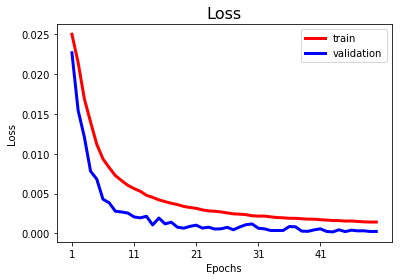

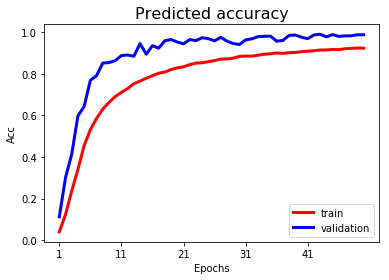

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
f = open('./result/ash_sand_1_16_vgg13_result.txt', 'a')

print('loss_train: ' + str(loss_train))
print('loss_val: ' + str(loss_val))
print('acc_train: ' + str(acc_train))
print('acc_val: ' + str(acc_val))
f.write('loss_train: ' + str(loss_train) + '\n')
f.write('loss_val: ' + str(loss_val) + '\n')
f.write('acc_train: ' + str(acc_train) + '\n')
f.write('acc_val: ' + str(acc_val) + '\n')
f.close()

# 绘制第一个图，在一幅图上画两条曲线
plt.figure()
plt.title("Loss",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(1, epochs + 1, 10.0))
plt.plot(range(1,epochs + 1), loss_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), loss_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

# 绘制第二个图，在一幅图上画两条曲线
plt.figure()
plt.title("Predicted accuracy",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.xticks(np.arange(1, epochs + 1, 10.0))
plt.plot(range(1,epochs + 1), acc_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), acc_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

plt.show()

In [8]:
from openpyxl import Workbook # xlsx

def save(data, path):
    # xlsx
    workbook = Workbook()
    booksheet = workbook.active  # 获取当前活跃的sheet,默认是第一个sheet
    h = len(data) # 行数
    l = len(data[0]) #列数
    for i in range(h):
        for j in range(l):
            booksheet.cell(i+1, j+1).value = data[i][j]
    workbook.save(path)

save(best_matrix,'./result/ash_sand_1_16_vgg13_confusion_matrix.xlsx')

In [42]:
# 开始测试
since = time.time()
model.eval()
number = 0
matrix2 = [[0 for i in range(500)] for i in range(num_classes)]
f = open('./result/ash_sand_1_16_vgg13_result.txt', 'a')
print("=====start test=====")
f.write("=====start test=====")

# Iterate over data.
for data in dataloders_test:
    # get the inputs
    inputs, labels = data
    print('labels: ' + str(labels.data.cpu().numpy()))
    f.write('labels: ' + str(labels.data.cpu().numpy()) + '\n')

    # PyTorch更新至0.4.0后，将Variable和Tensor合并
    if use_gpu:
        inputs = inputs.cuda()
        labels = labels.cuda()

    # 先将网络中的所有梯度置0
    optimizer.zero_grad()

    # 网络的前向传播
    outputs = model(inputs)

    # 计算损失
    loss = loss_fn(outputs, labels)

    # 得到模型预测该样本属于哪个类别的信息
    _, preds = torch.max(outputs.data, 1)
    print('preds: ' + str(preds.data.cpu().numpy()))
    f.write('preds: ' + str(preds.data.cpu().numpy()) + '\n')
    for k in range(batch_size):
        matrix2[labels.data.cpu().numpy()[k]][number] = preds.cpu().numpy()[k]
        number += 1
        if number == 500:
            number = 0

time_elapsed = time.time() - since
print('Test complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
f.close()

=====start test=====
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

preds: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 2 3 3 4 3 3 3 3 3 4 4 4 4 3 4 4 4 3 4 3 3 3 4 4 3 4
 3 3 3 4 3 4 3 3 3 3 4 3 3 4 4 3 3 4 3 3 4 4 3 4 4 4 3 4 4 4 4 4 4 4 4 4 4
 4 4 4 3 3 3 4 3 3 3 3 3 3 3 3 3 3 4 3 4 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]
labels: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]
preds: [4 4 3 3 3 4 4 4 4 4 4 3 3 4 4 4 3 3 3 3 3 3 4 4 4 4 3 4 4 4 3 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4
 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 3 4 3 3 3 3 3 3 4 4
 4 3 3 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 3 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]
labels: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

preds: [ 7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7 41  7  7  7  7  7  7  7  7  7  7 41  7  7  7  7  7  7  7  7  7  7  7
  7  7 38  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8]
labels: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8]
preds: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8

preds: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11]
labels: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11]
preds: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 1

preds: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13]
labels: [14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14]
preds: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 13 13 13 13 1

preds: [15 15 15 15 15 15 16 15 15 15 15 15 15 15 15 15 15 16 15 15 15 15 15 15
 15 16 15 16 16 15 15 15 15 15 16 15 15 15 15 16 15 15 15 15 15 15 15 15
 15 15 16 15 15 15 16 15 15 15 16 16 16 16 16 16 16 15 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 15 16 15 15 16 16 16 16 16 16 16
 16 16 15 15 15 15 15 15 15 15 16 15 15 16 15 15 15 15 15 15 15 16 15 15
 15 15 15 15 15 15 15 15 16 15 16 16 16 16 16 15 15 16 16 16 15 16 15 15
 15 15 16 15 15 15]
labels: [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17]
preds: [16 16 15 15 15 15 15 15 15 15 15 16 16 16 16 15 16 15 16 16 1

preds: [20 20 20 20 20 20 20 20 20 20 20 20 20 20 19 20 20 19 20 19 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 19 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20]
labels: [19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19]
preds: [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 2

preds: [21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 21 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 21 22 21 22 22 21 22 22 21 22 22 21 21 22 22 22 21 21 22 21
 21 21 22 21 21 21]
labels: [22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22]
preds: [22 22 22 22 22 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22 2

preds: [24 28 28 24 28 28 28 28 28 28 28 24 28 28 28 28 28 28 28 28 28 28 24 28
 24 28 28 28 24 24 28 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 23 24 24 24 23 24 23 24 23 24 24 23 24 24 24 24 24 24
 24 24 24 24 24 24]
labels: [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25]
preds: [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 2

preds: [27 27 27 32 32 32 27 32 27 32 32 27 32 27 27 27 27 27 27 27 27 27 27 32
 32 32 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
labels: [27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
preds: [27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 2

preds: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29]
labels: [30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]
preds: [29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 2

preds: [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32]
labels: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33]
preds: [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 3

preds: [35 35 35 35 35 35 35 35 34 34 34 35 34 34 34 34 34 34 35 34 34 34 35 35
 34 35 35 34 34 34 34 34 34 34 35 34 35 34 34 34 34 34 34 34 35 35 34 34
 34 34 34 34 34 34 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 34 35 35 34 34 35 35 34 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 35 35 35 34 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
labels: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35]
preds: [35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 3

preds: [38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38]
labels: [38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38]
preds: [38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 3

preds: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 42 41]
labels: [41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41]
preds: [42 41 41 41 41 42 41 41 42 42 42 42 42 42 42 42 42 41 41 41 4

preds: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43]
labels: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44
 44 44 44 44 44 44]
preds: [43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 4

In [58]:
# conc 浓度
matrix_conc = [[0 for i in range(500)] for i in range(num_classes)]
concentration = []
density = 200
while True:
    concentration.append(density)
    if density == 780:
        break
    if density < 600:
        density += 50
    else:
        density += 5
print(concentration)
for x in range(num_classes):
    for y in range(500):
        matrix_conc[x][y] = matrix2[x][y] - concentration[x]

for label in range(num_classes):
    count = 0
    print(label)
    for k in range(500):
        if matrix2[label][k] == label:
            count += 1
    print(" - 预测正确数量：" + str(count))
        # 方差
    var = np.var(matrix_conc[label])
    print(" - 方差：" + str(var))

[200, 250, 300, 350, 400, 450, 500, 550, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780]
0
 - 预测正确数量：500
 - 方差：0.0
1
 - 预测正确数量：339
 - 方差：0.21831599999999998
2
 - 预测正确数量：497
 - 方差：0.005964000000000001
3
 - 预测正确数量：421
 - 方差：0.20726399999999998
4
 - 预测正确数量：309
 - 方差：0.2421240000000001
5
 - 预测正确数量：419
 - 方差：0.18118399999999996
6
 - 预测正确数量：471
 - 方差：0.054636000000000004
7
 - 预测正确数量：467
 - 方差：63.660076000000004
8
 - 预测正确数量：500
 - 方差：0.0
9
 - 预测正确数量：494
 - 方差：0.358156
10
 - 预测正确数量：332
 - 方差：0.274896
11
 - 预测正确数量：500
 - 方差：0.0
12
 - 预测正确数量：442
 - 方差：6.080044
13
 - 预测正确数量：500
 - 方差：0.0
14
 - 预测正确数量：143
 - 方差：0.204204
15
 - 预测正确数量：491
 - 方差：0.6363359999999999
16
 - 预测正确数量：325
 - 方差：0.2275
17
 - 预测正确数量：388
 - 方差：6.968399999999999
18
 - 预测正确数量：358
 - 方差：6.134223999999997
19
 - 预测正确数量：27
 - 方差：0.051084
20
 - 预测正确数量：480
 - 方差：0.03839999999999999
21
 - 预测正确数量：498
 -

In [60]:
var_sum = 0
for label in range(num_classes):
    var_sum += np.var(matrix_conc[label])
var_ave = var_sum / num_classes
print("平均方差：" + str(var_ave))

平均方差：2.1544416000000006


In [61]:
acc_count = 0
for label in range(num_classes):
    for k in range(500):
        if matrix2[label][k] == label:
            acc_count += 1
print("测试集正确率：" + str(acc_count/len(image_datasets['test'])))

测试集正确率：0.7973333333333333


In [62]:
# 75%-78%浓度方差
var_sum2 = 0
for label in range(38, 45):
    var_sum2 += np.var(matrix_conc[label])
var_ave2 = var_sum2 / num_classes
print("75%-78%浓度平均方差：" + str(var_ave2))

75%-78%浓度平均方差：0.04356044444444444


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


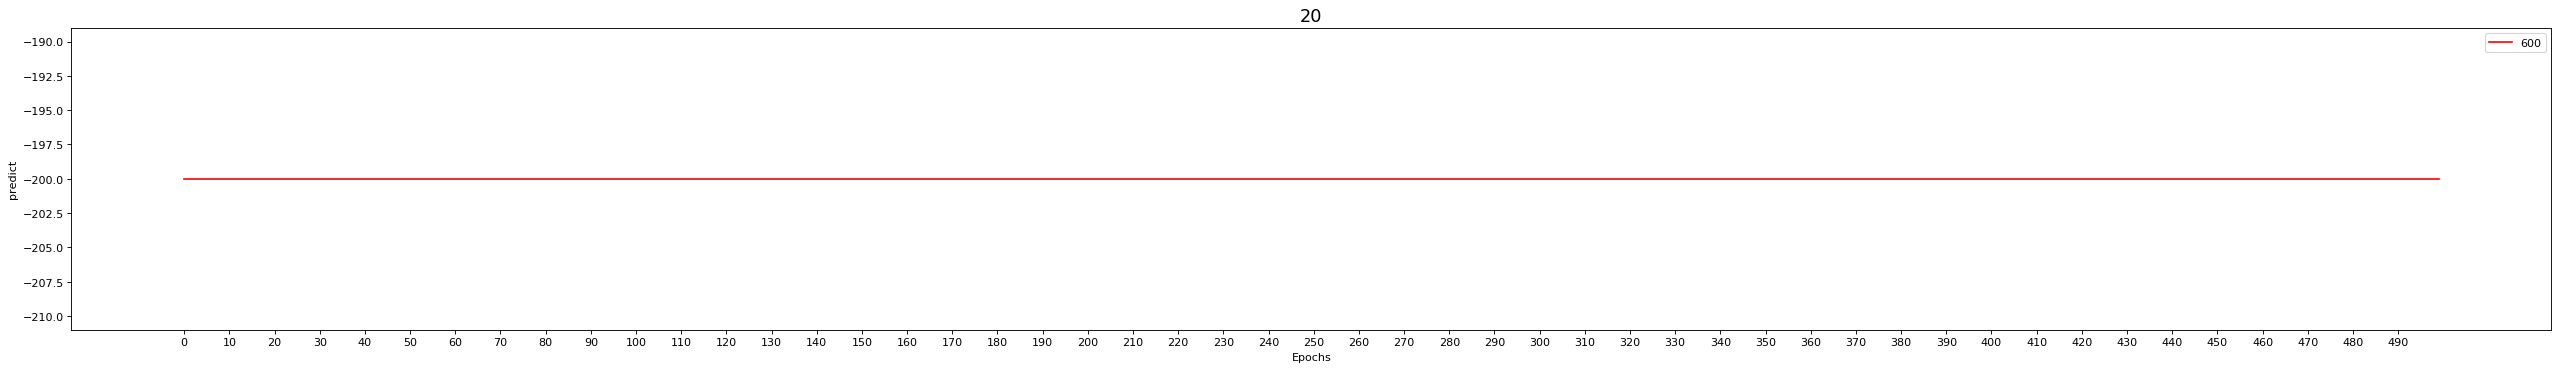

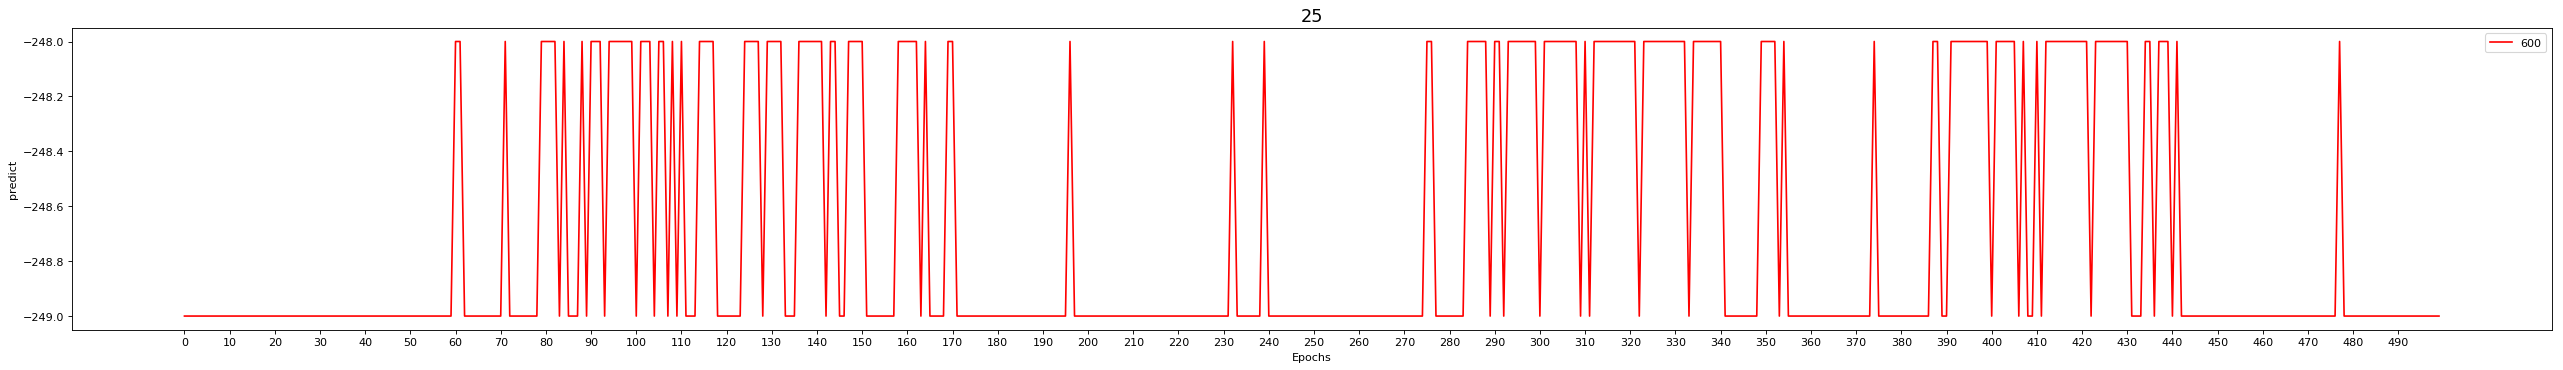

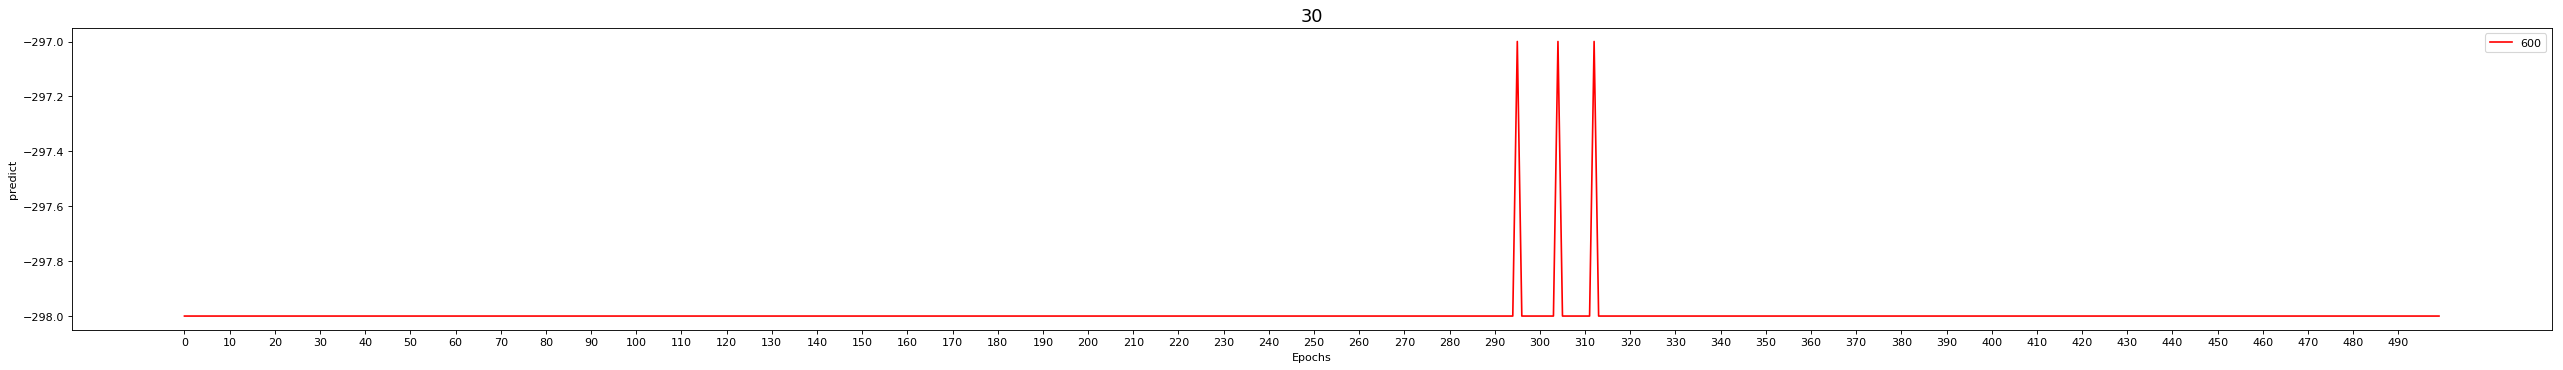

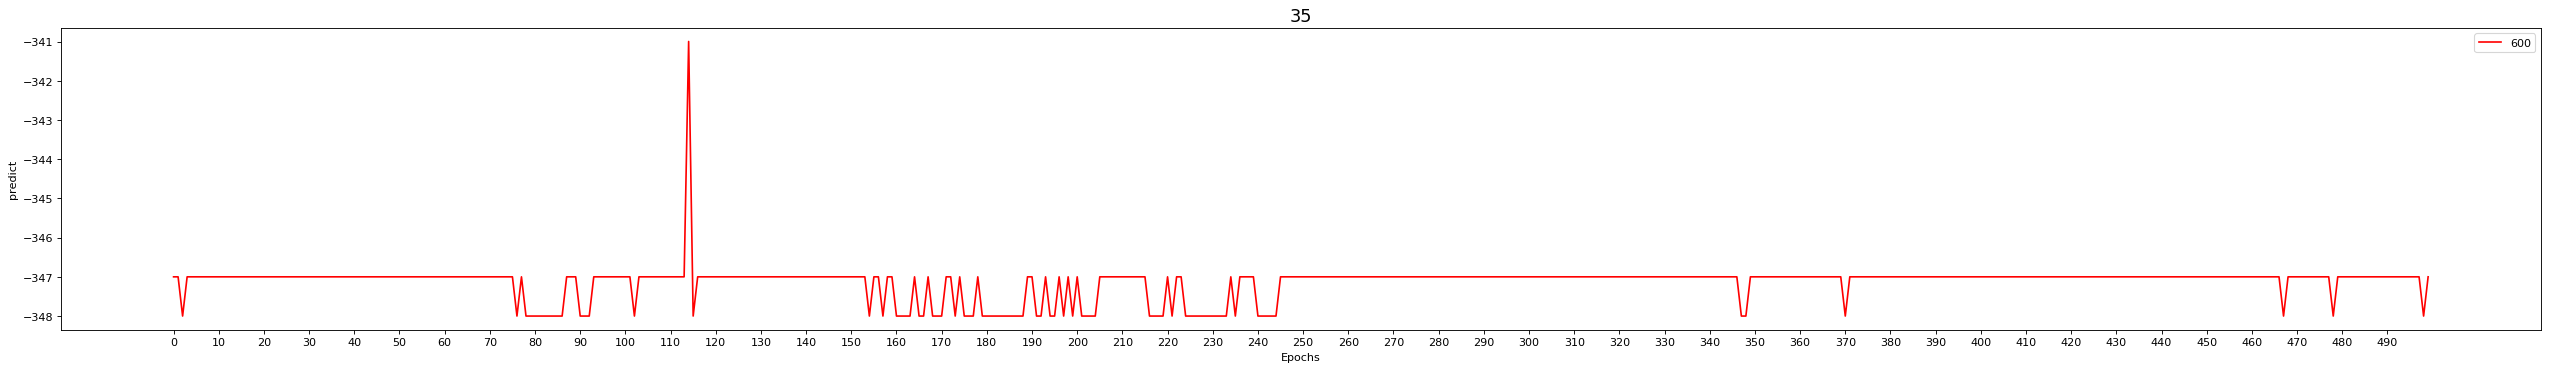

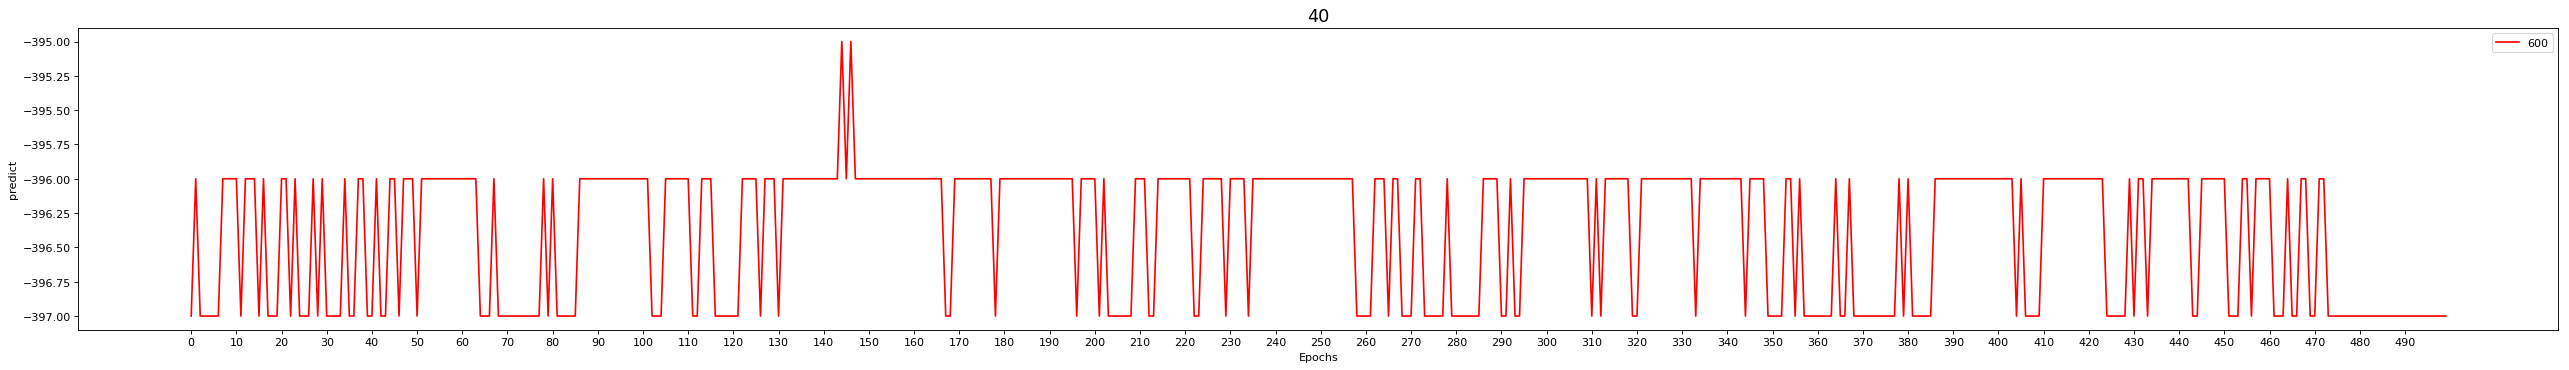

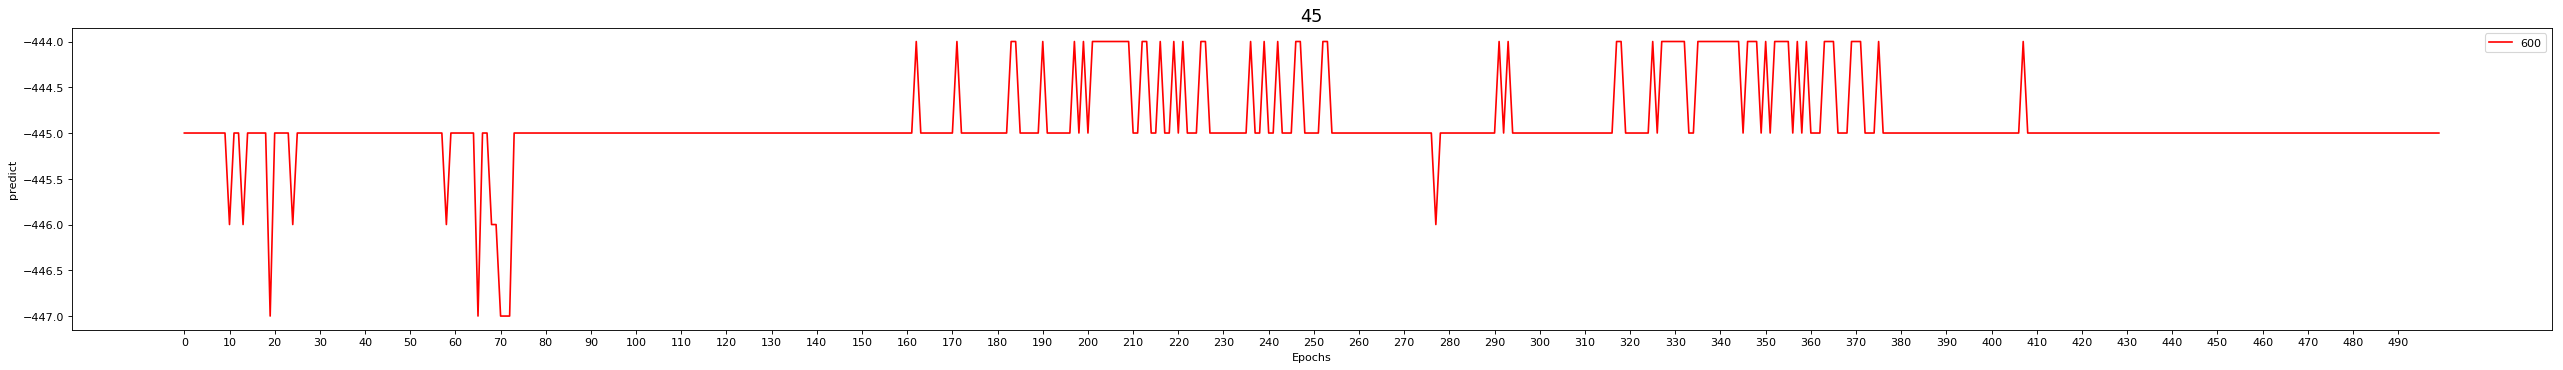

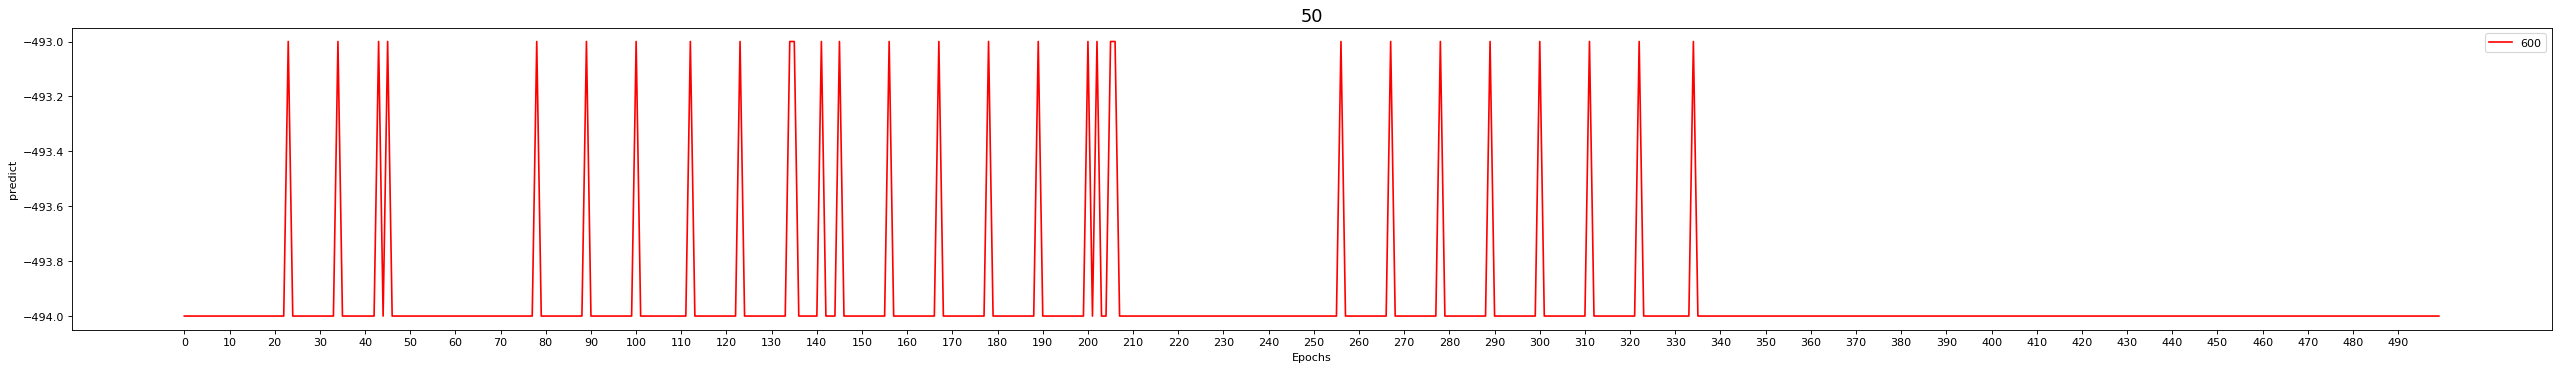

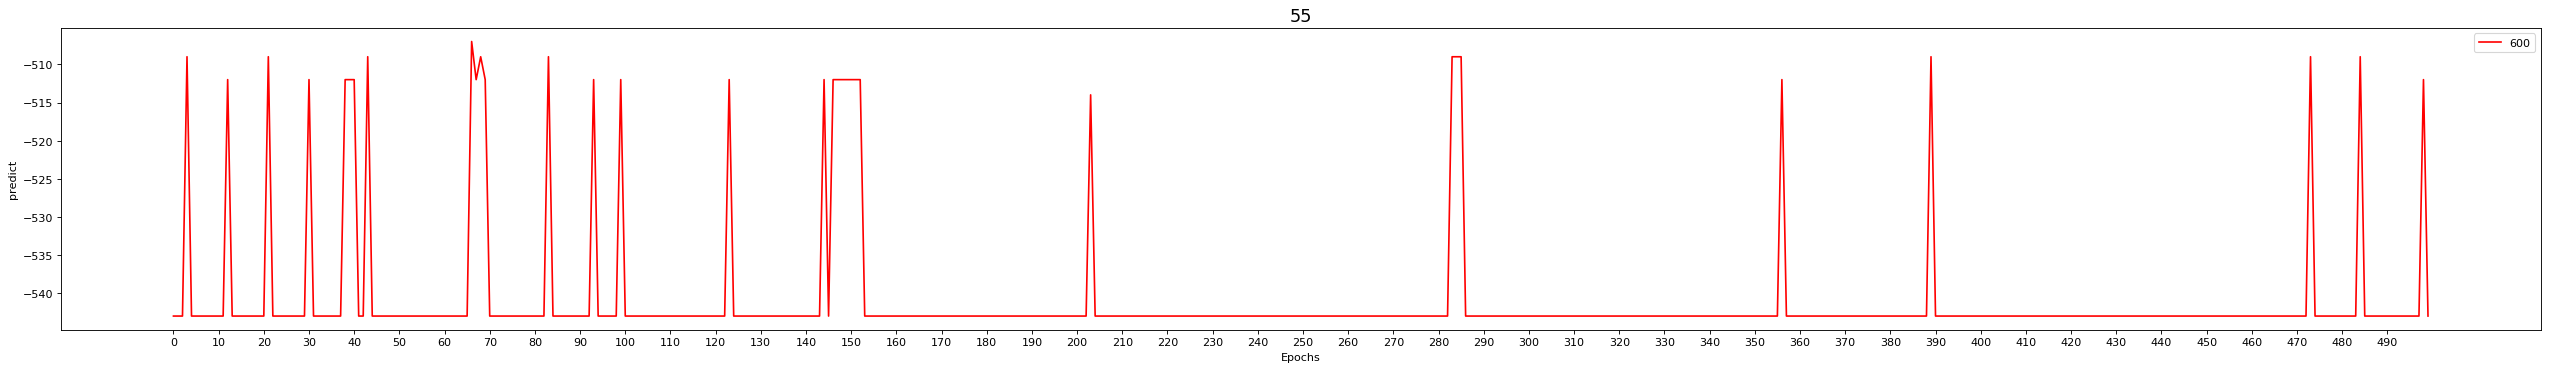

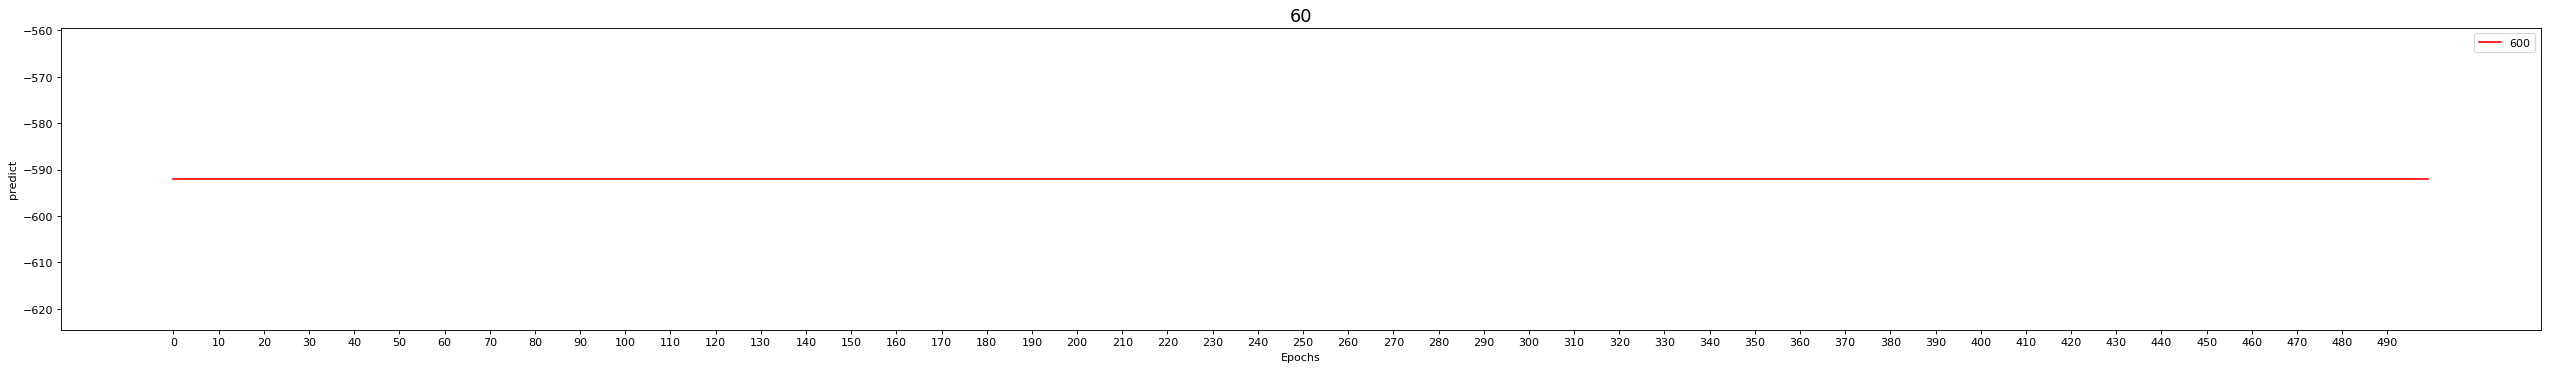

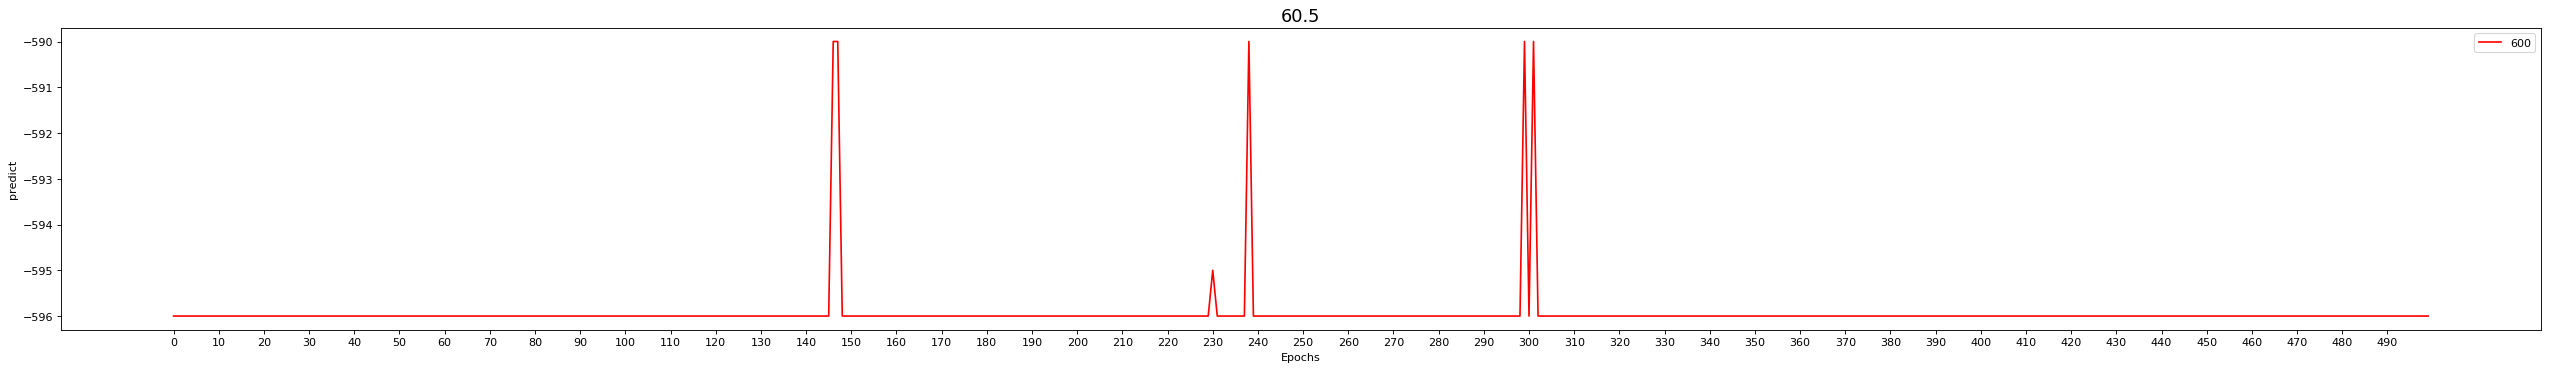

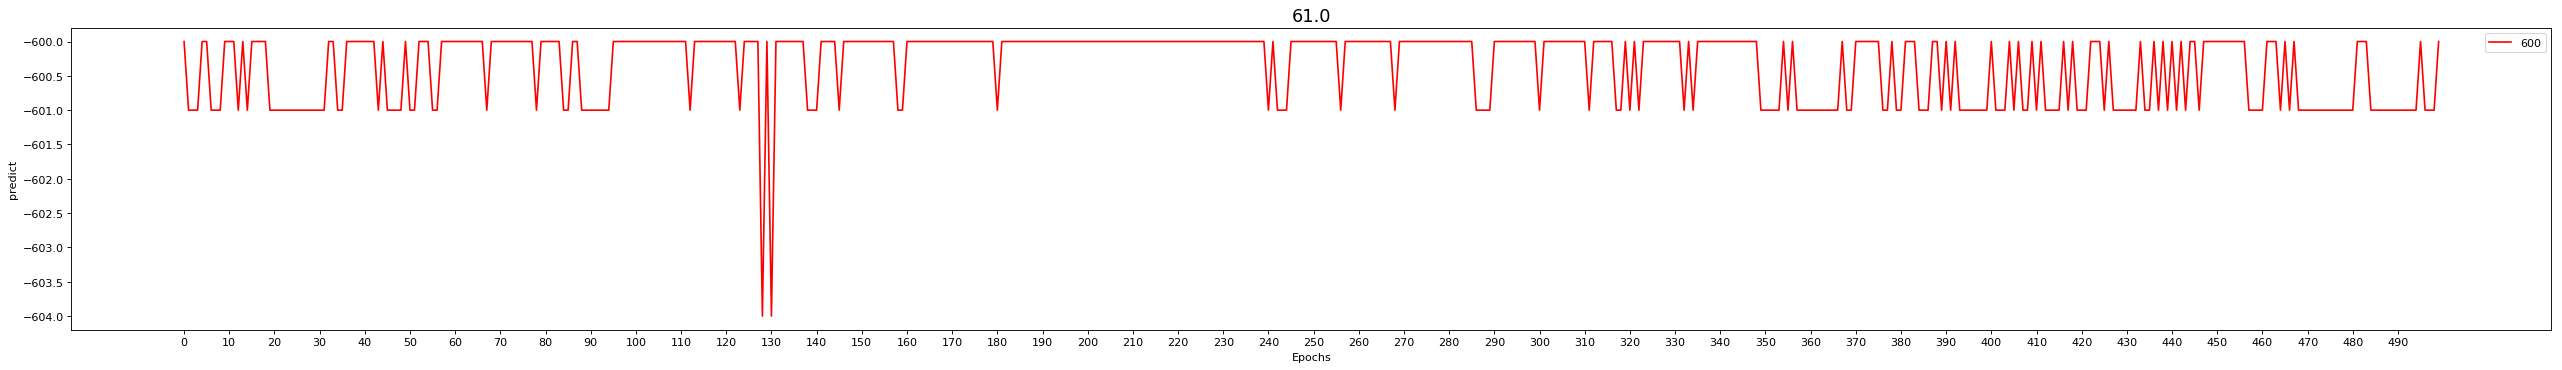

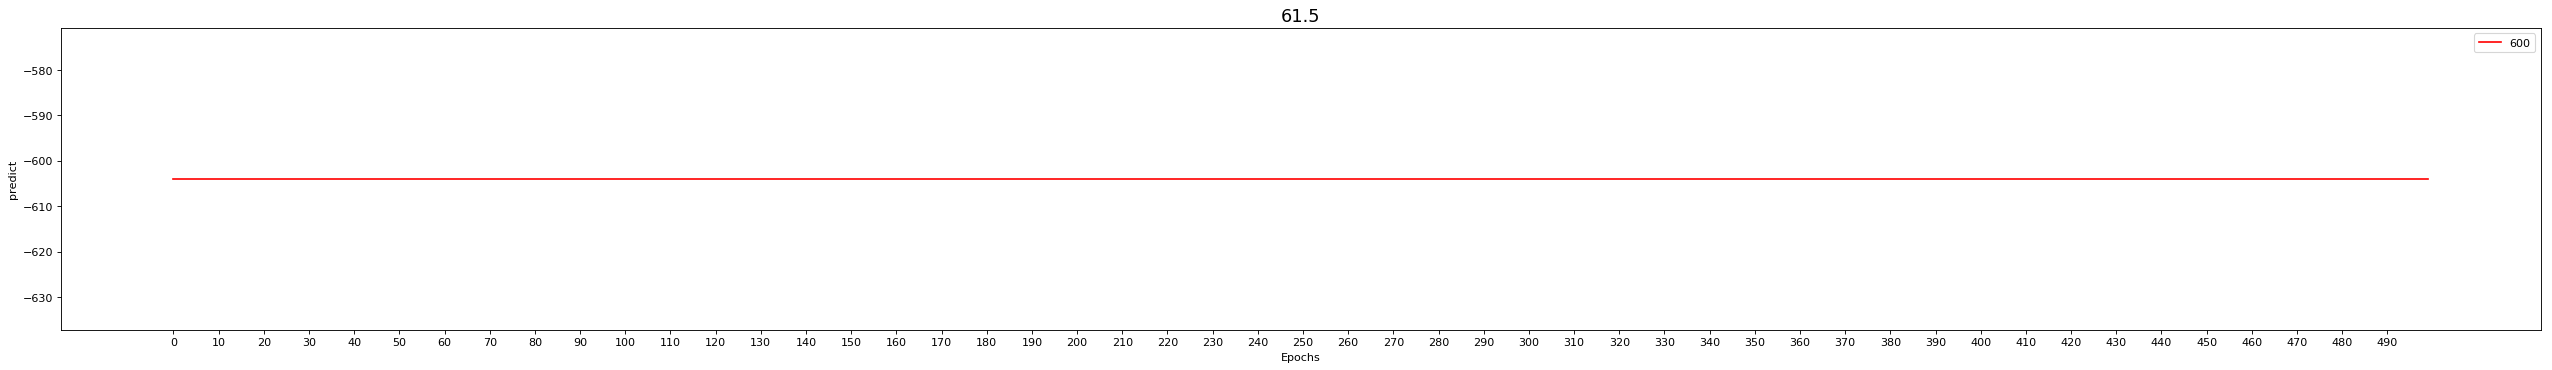

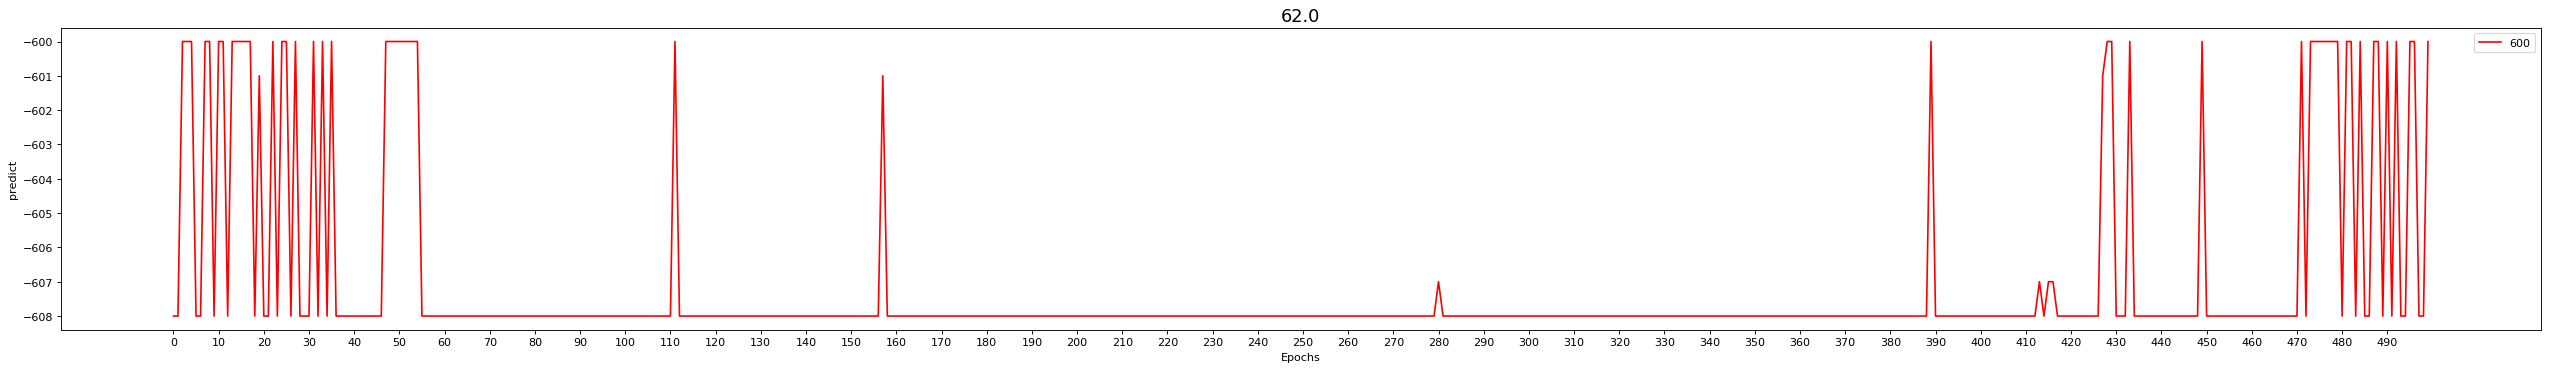

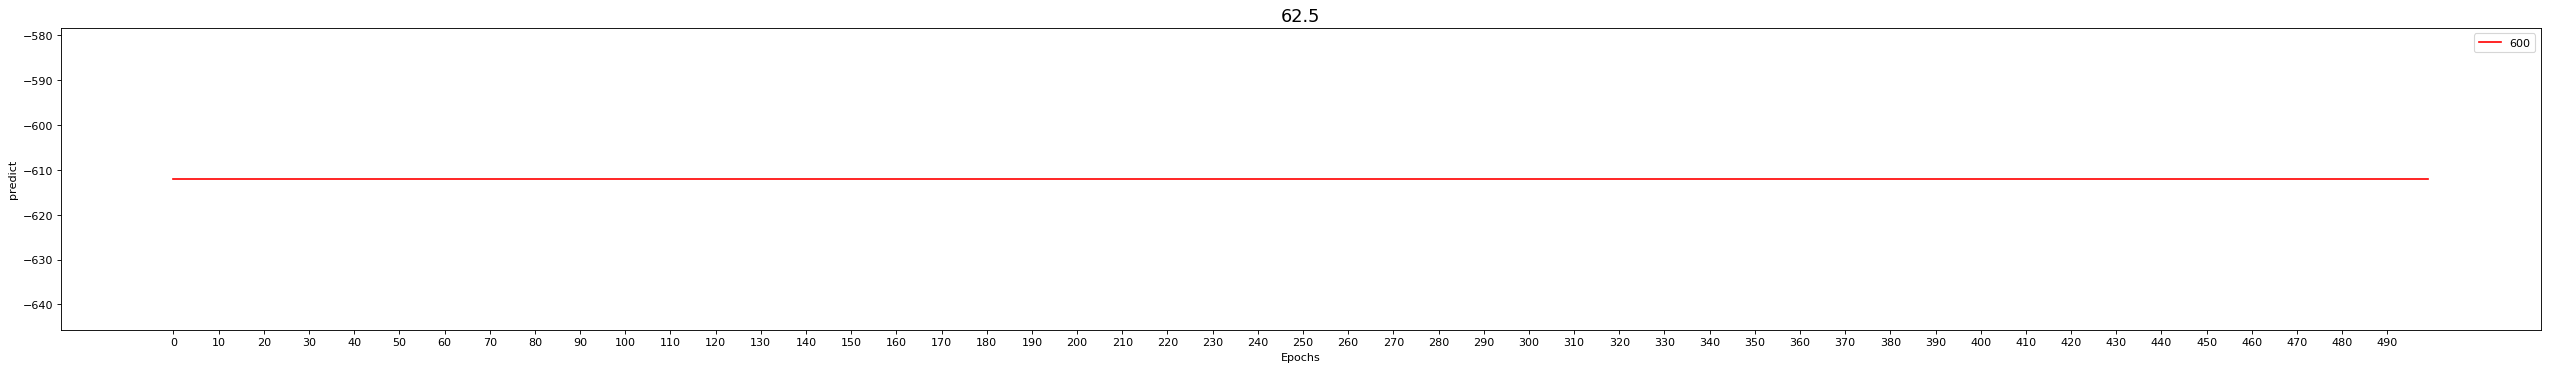

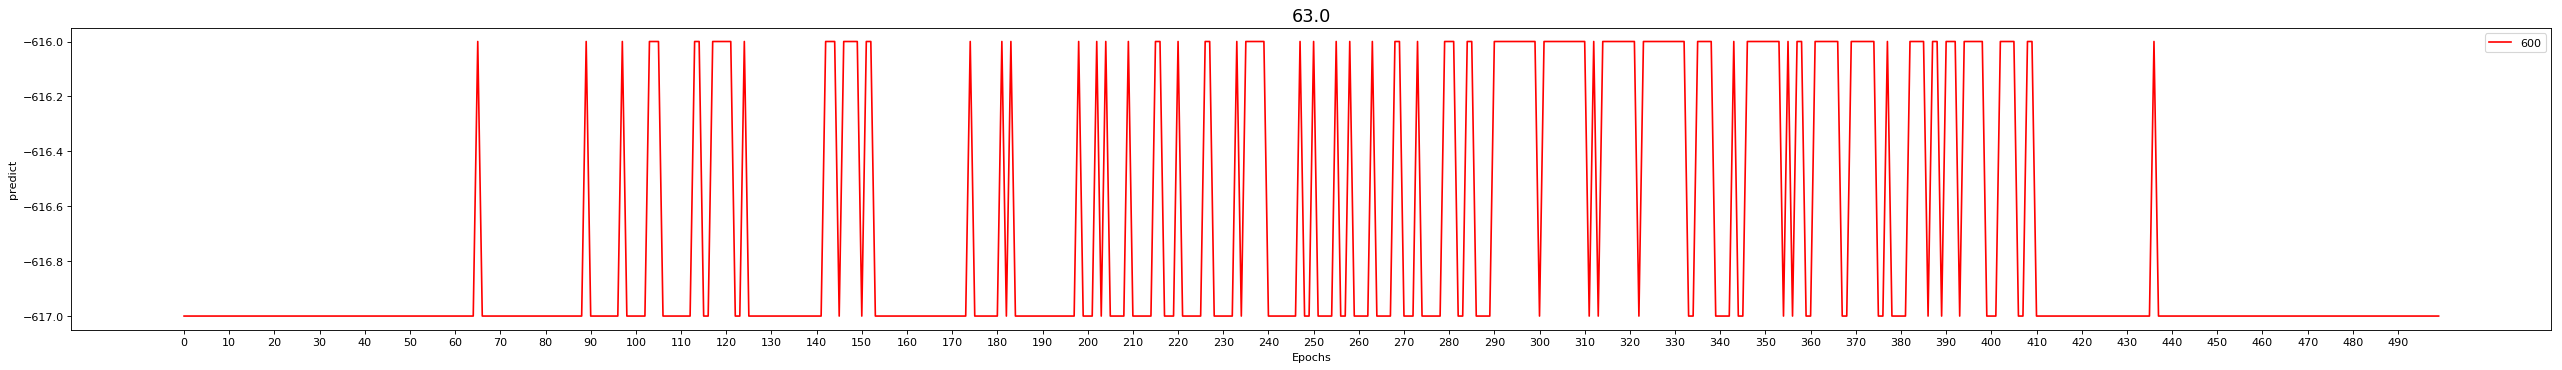

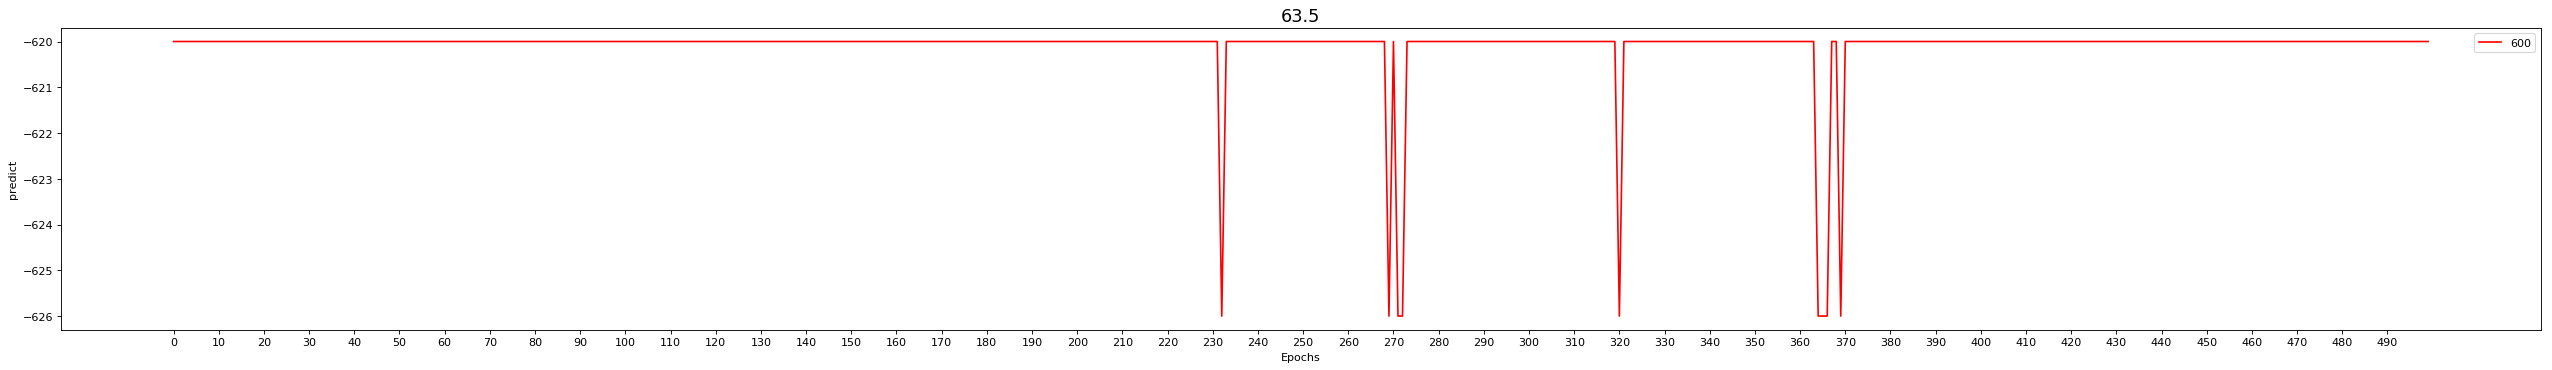

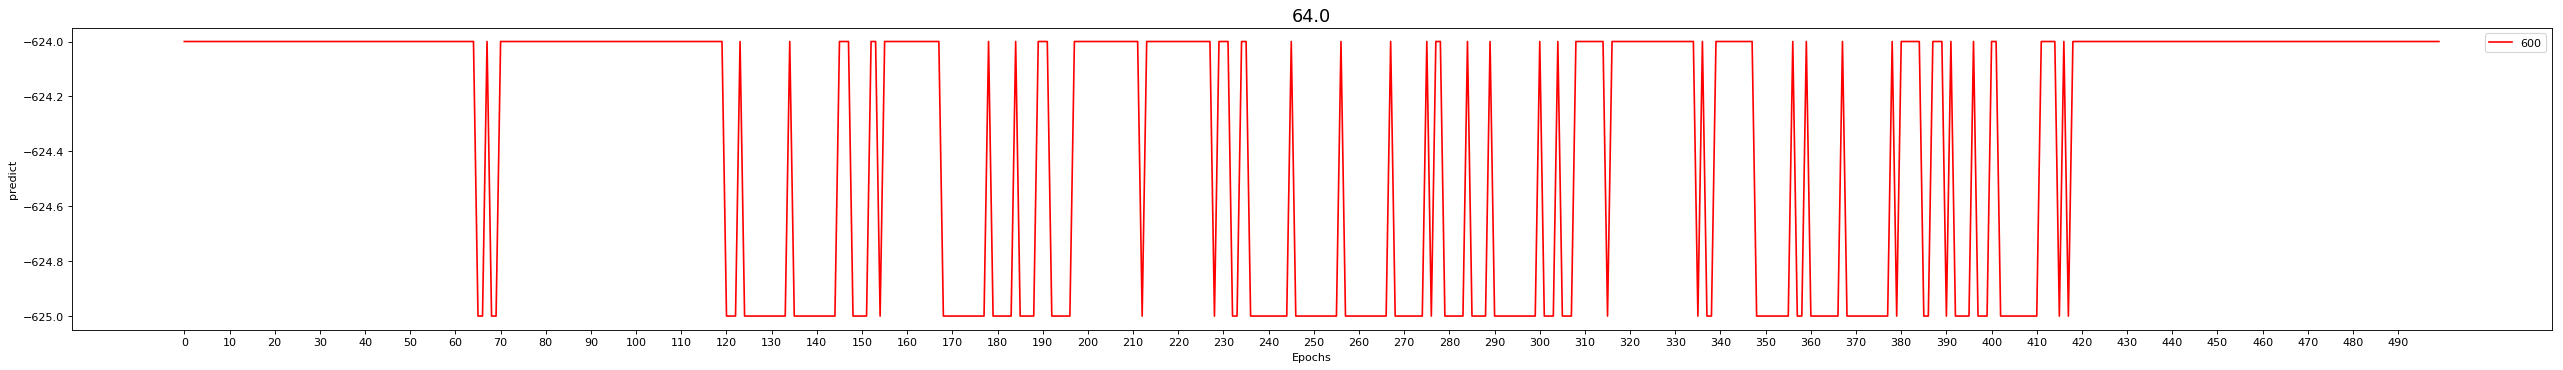

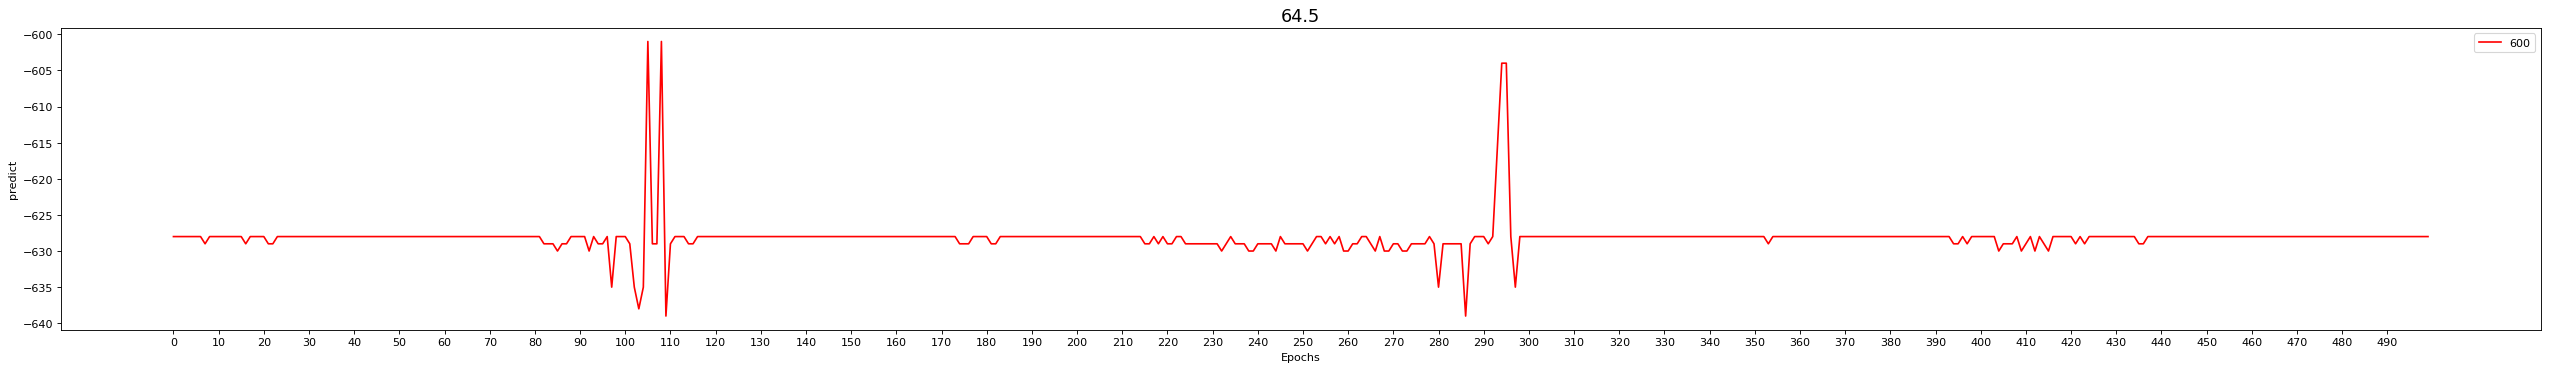

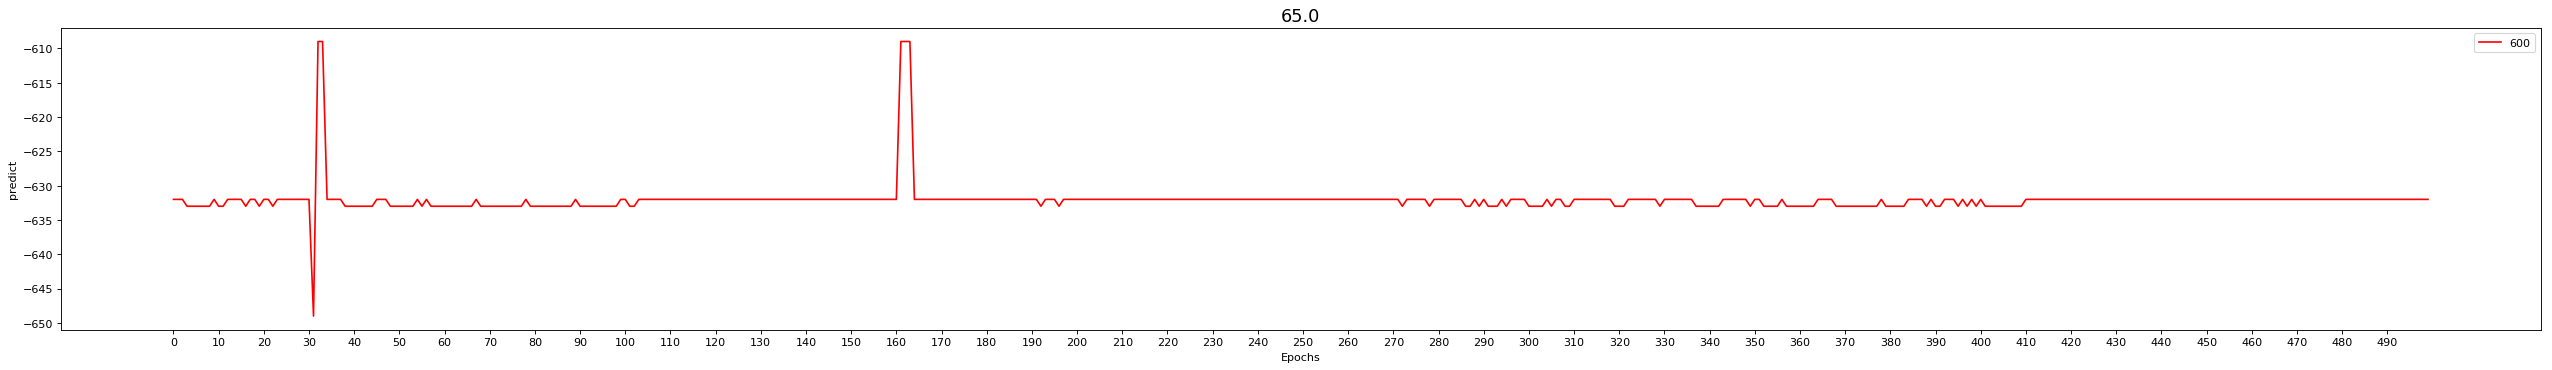

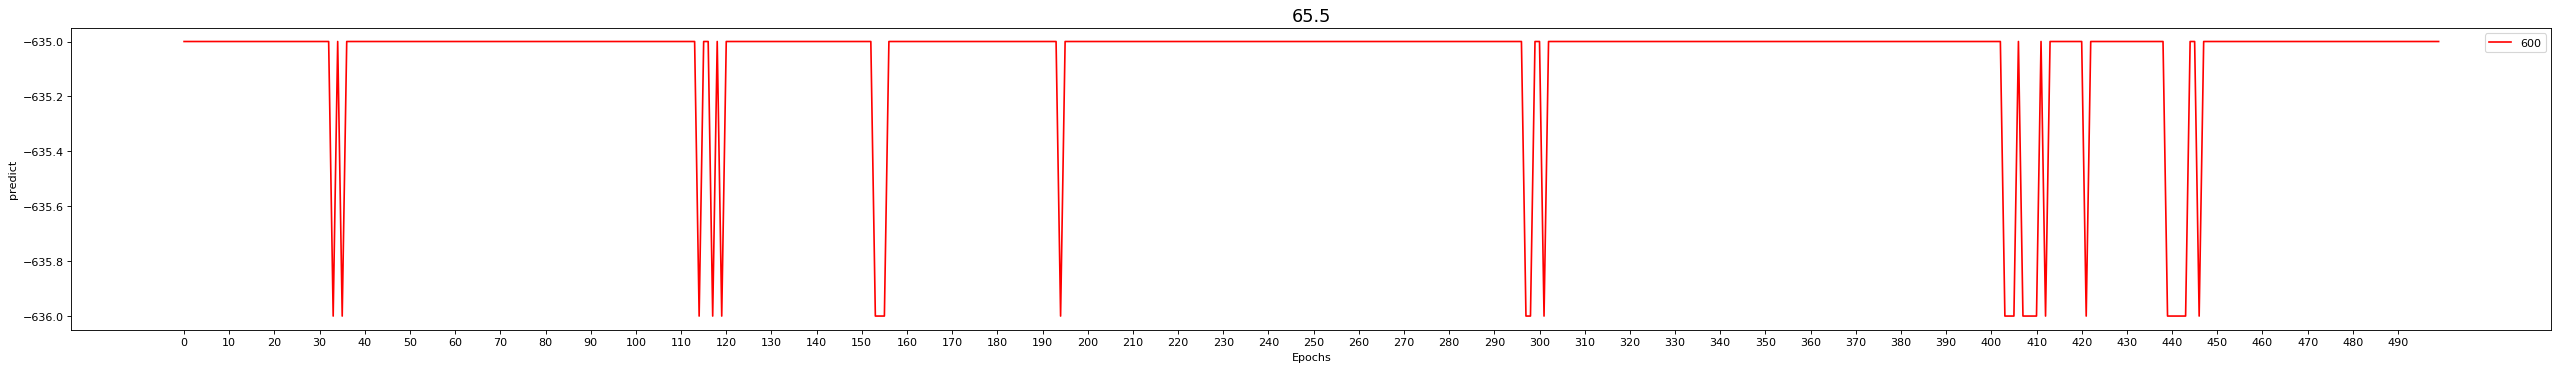

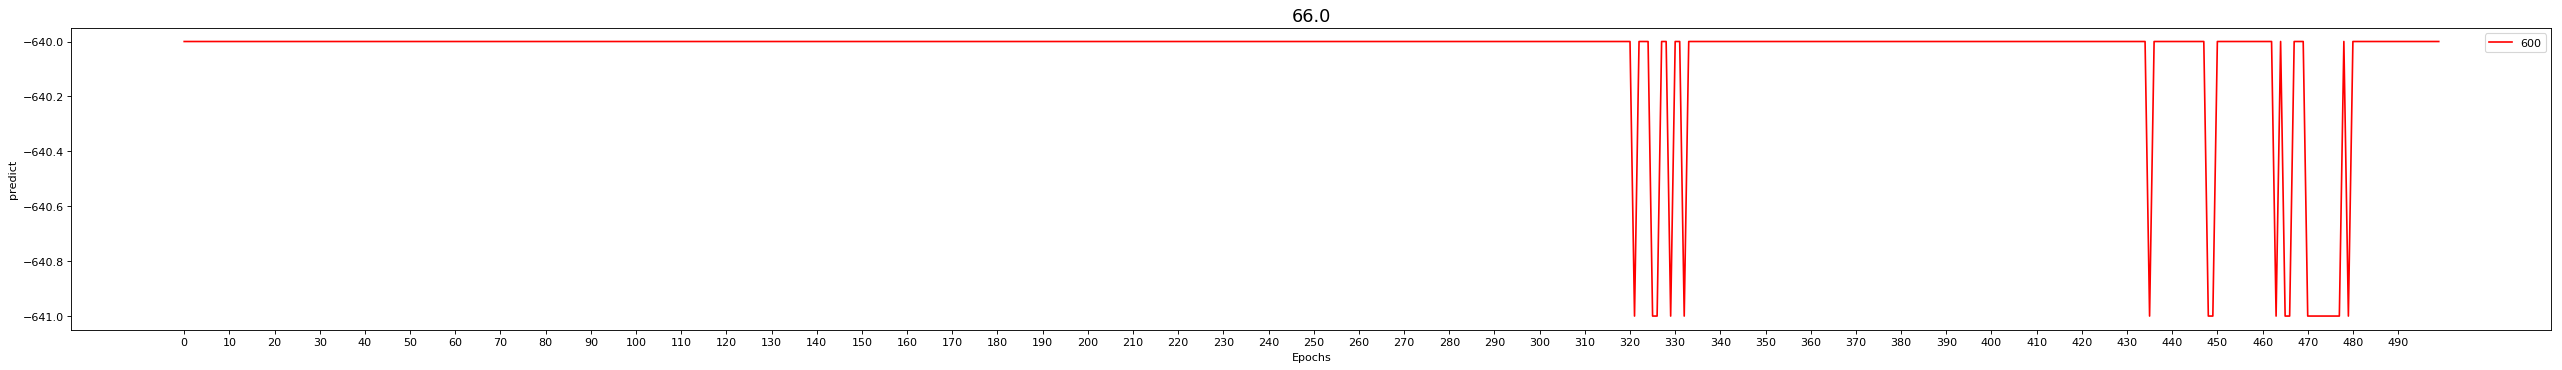

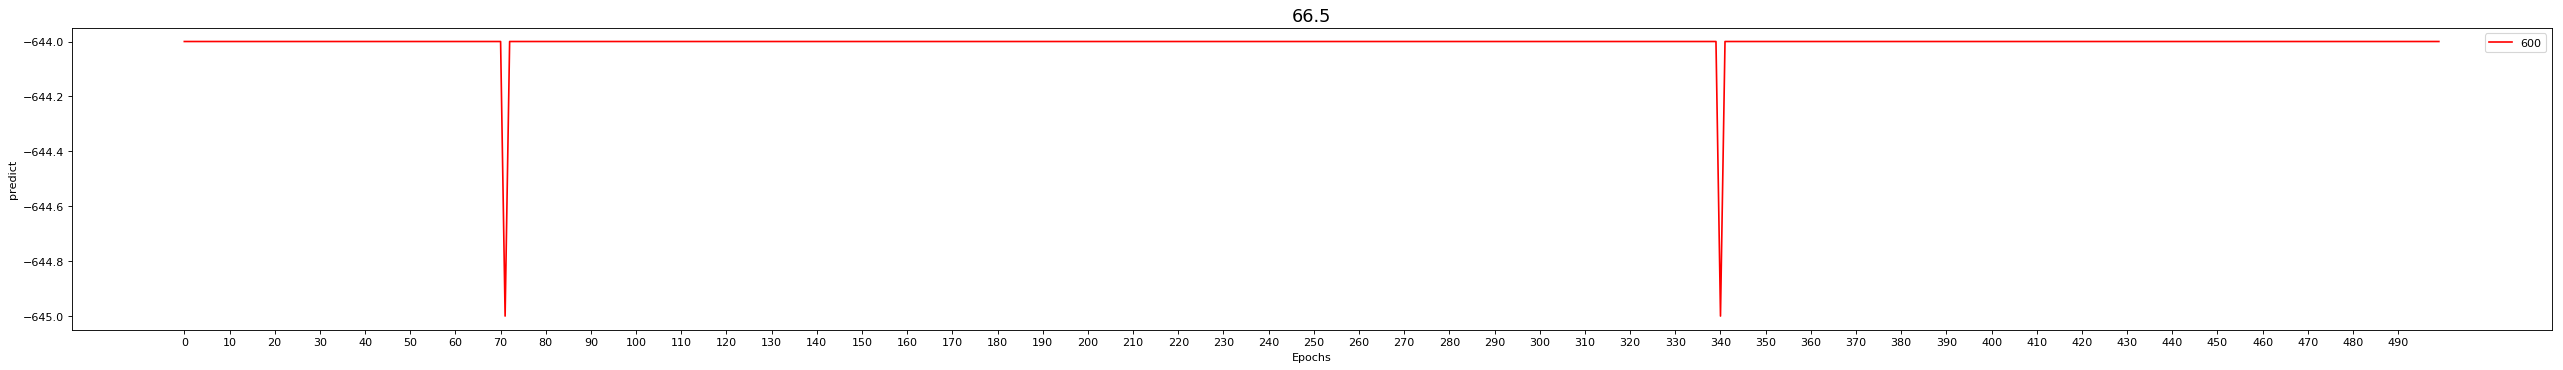

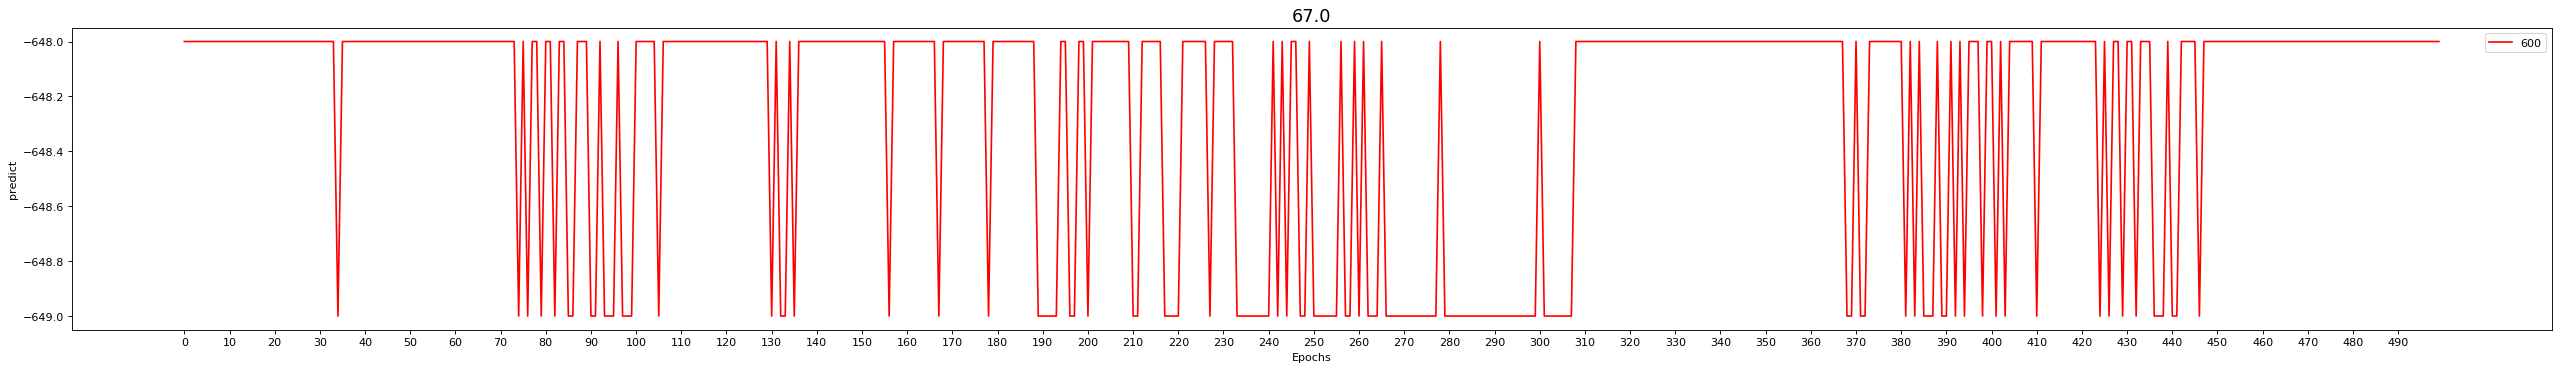

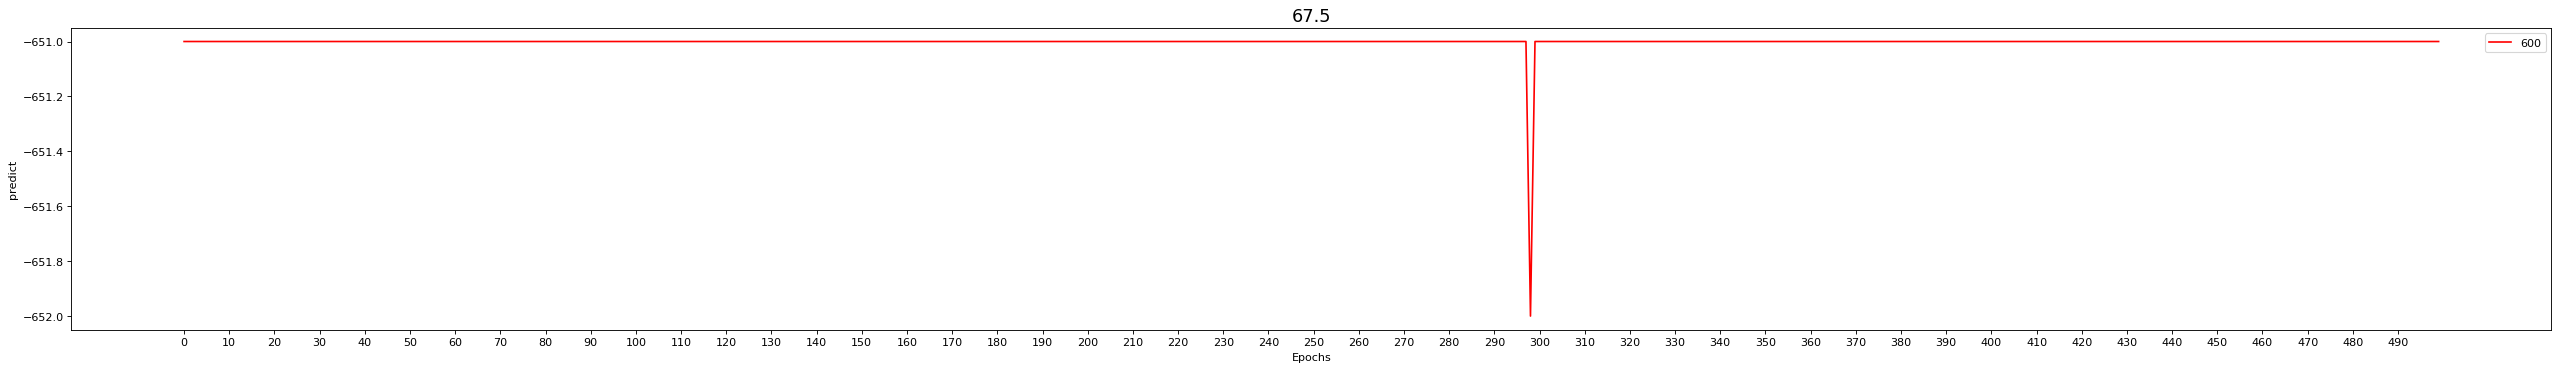

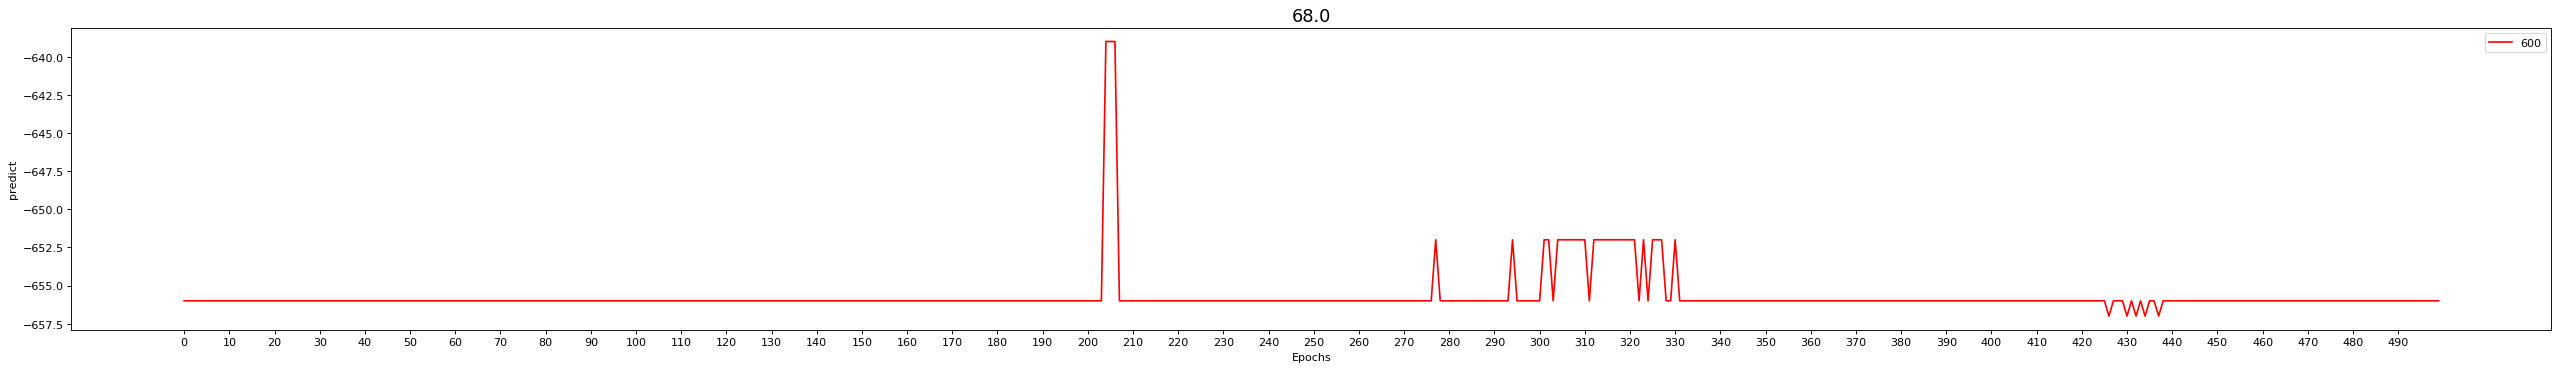

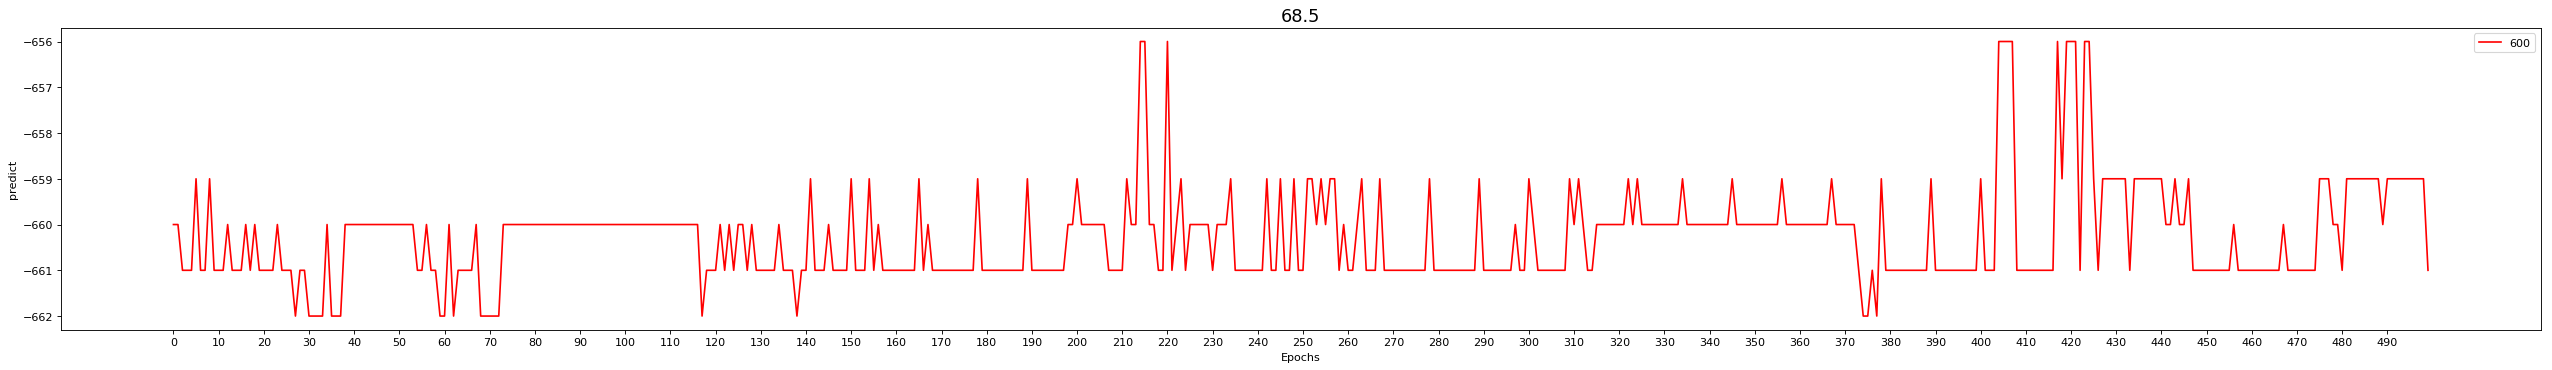

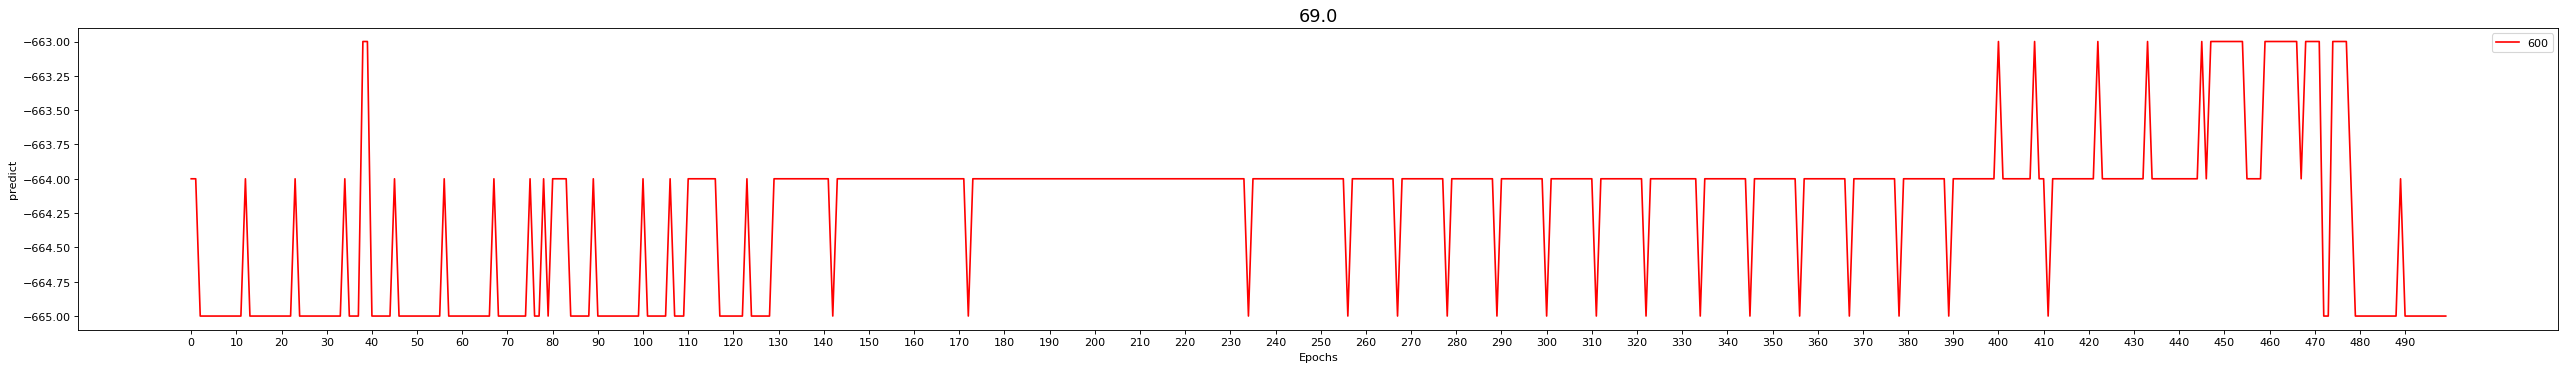

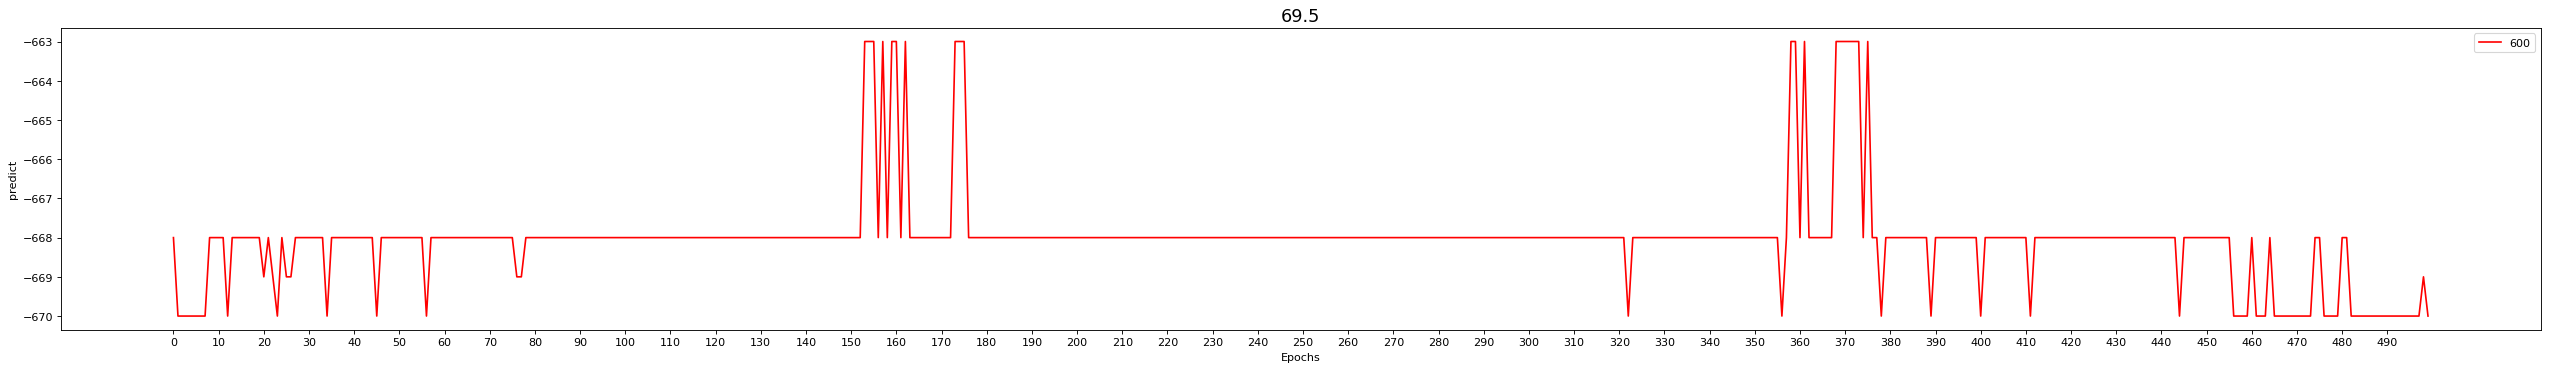

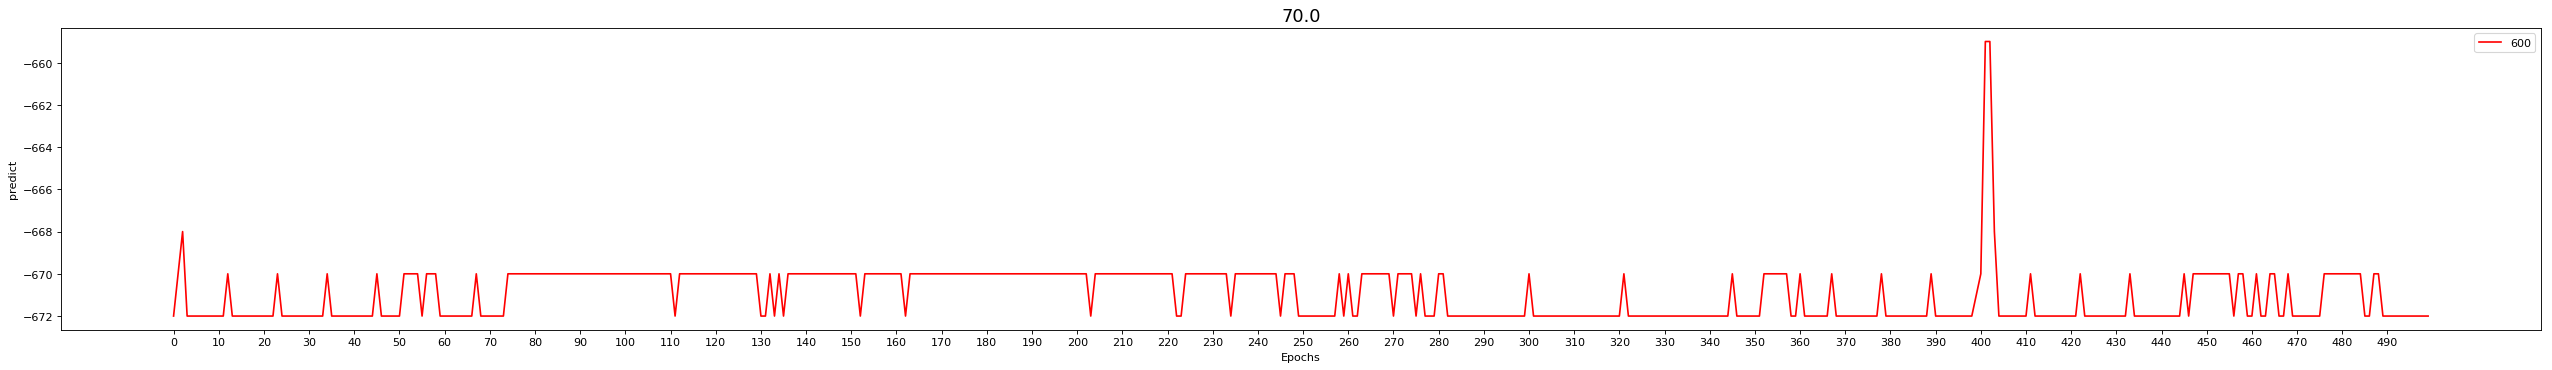

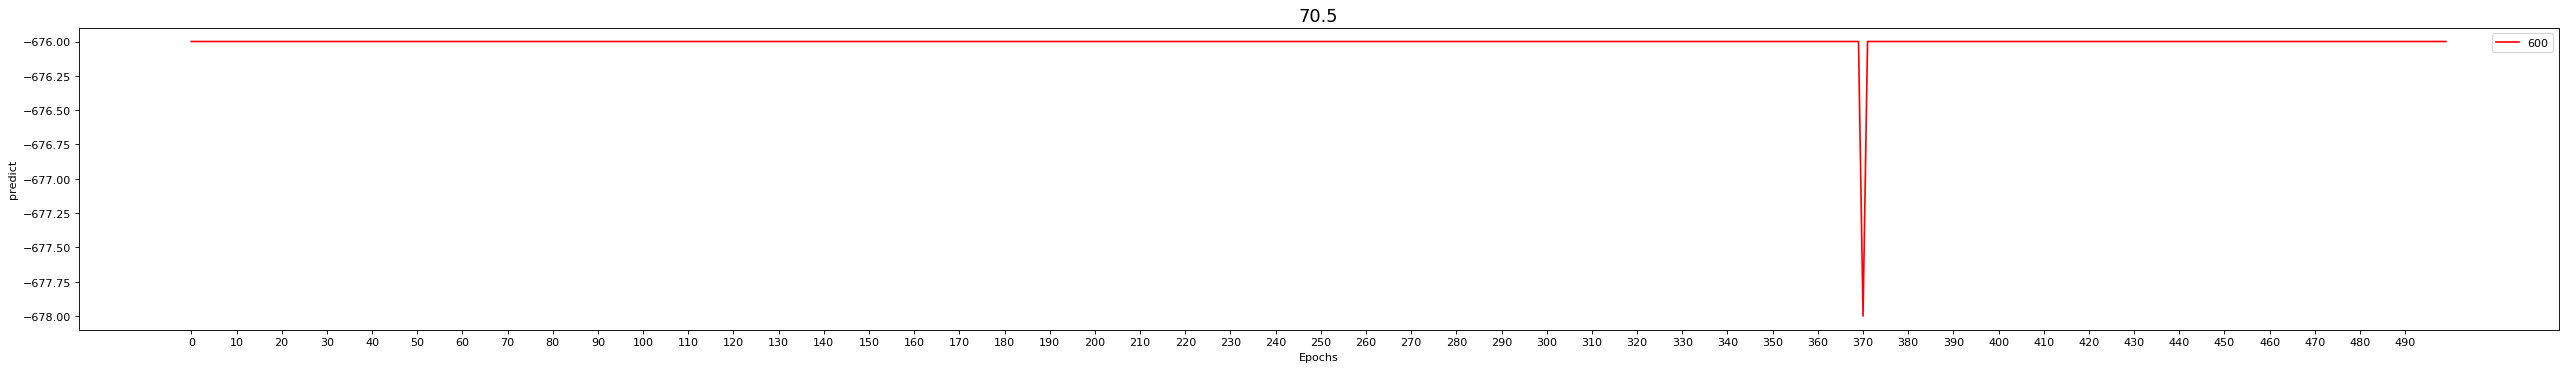

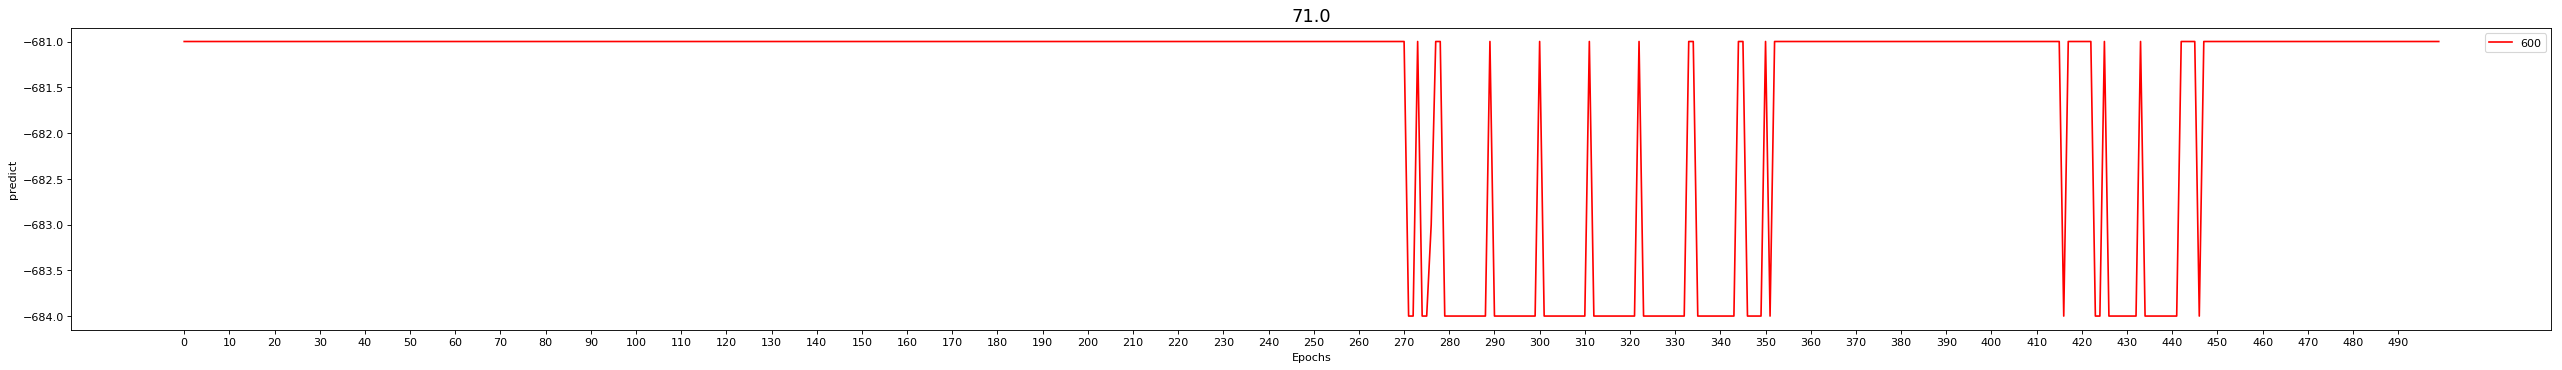

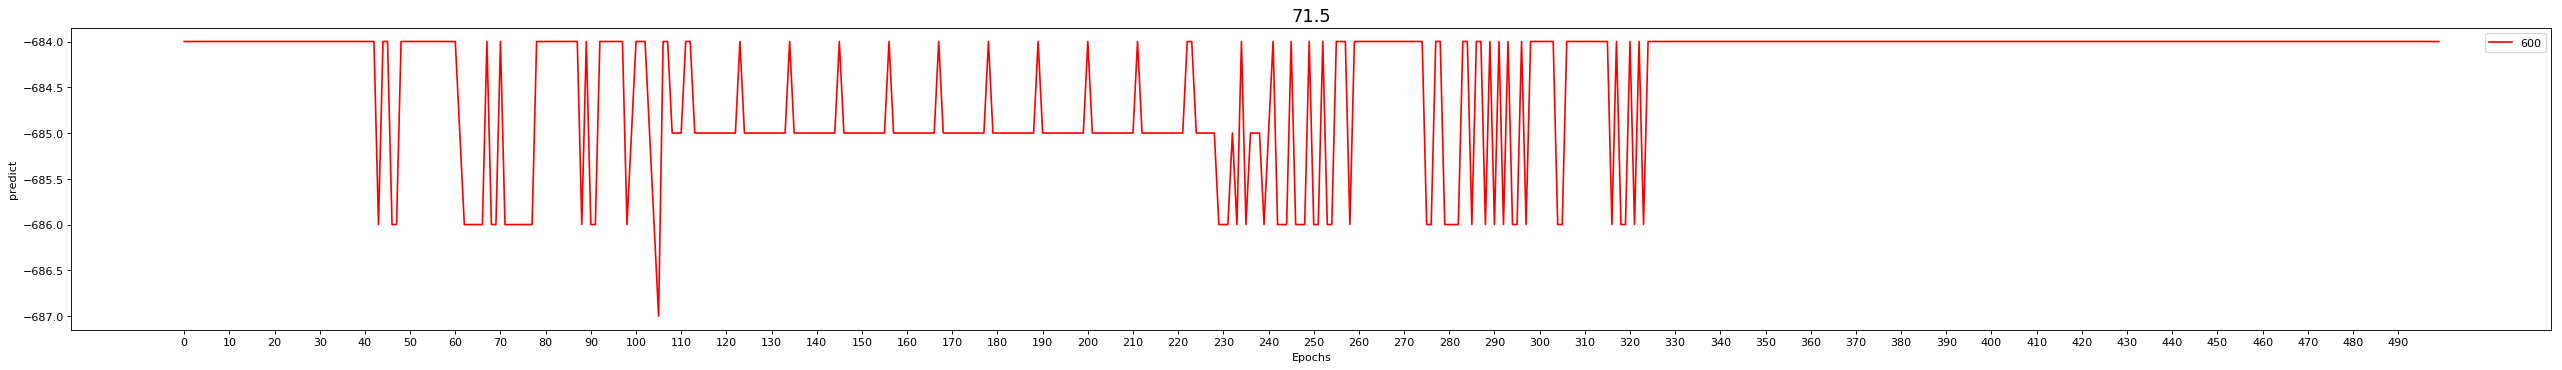

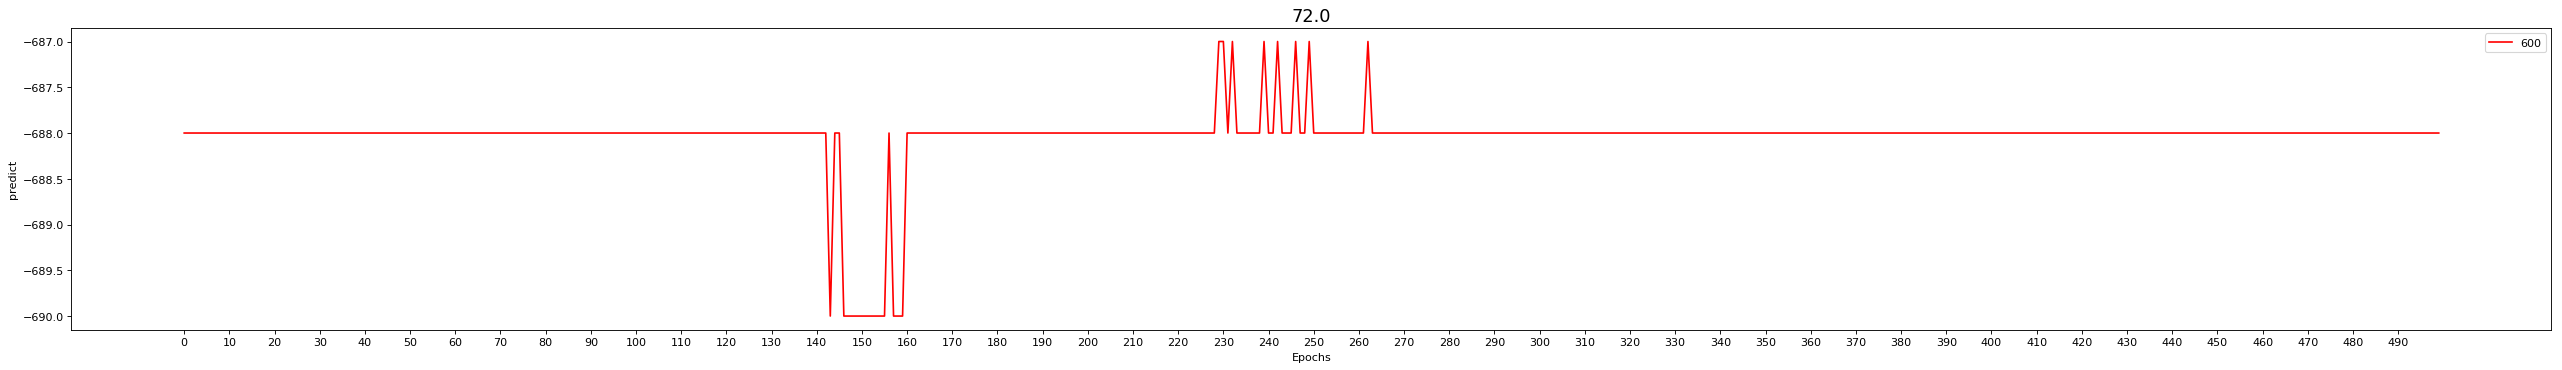

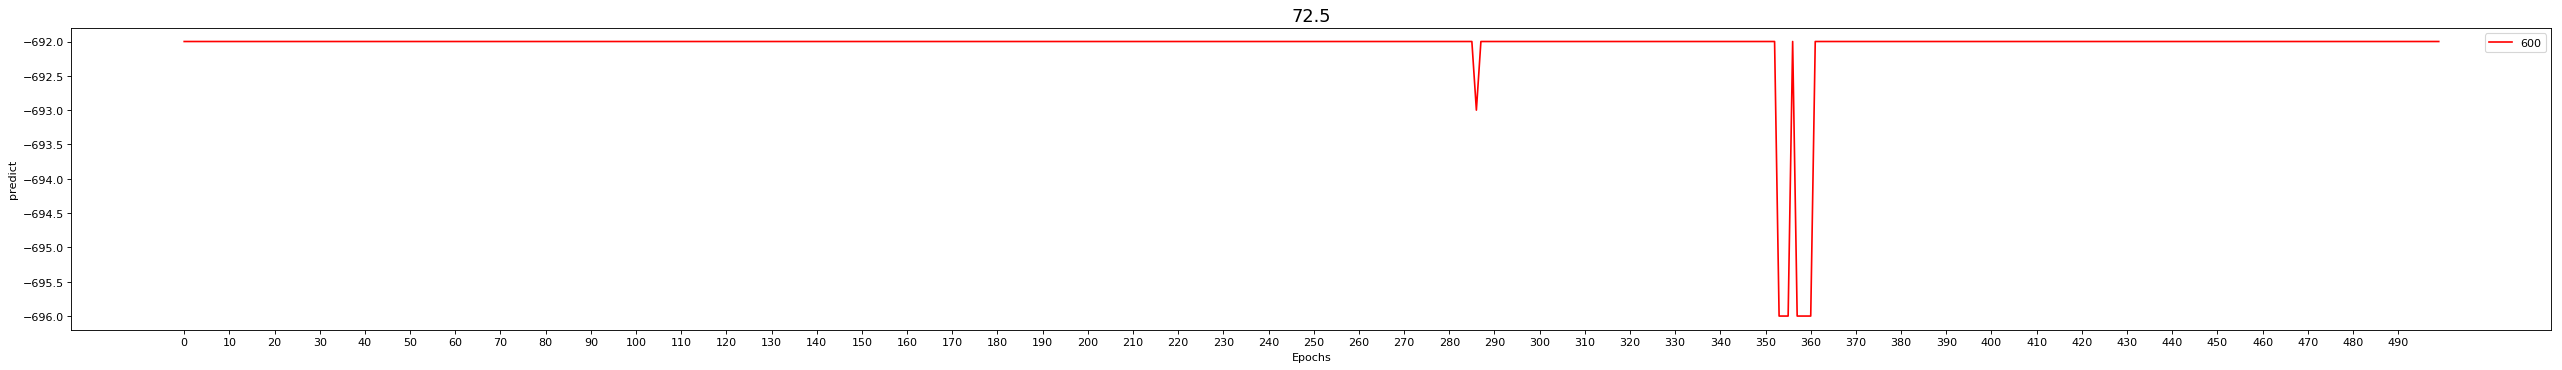

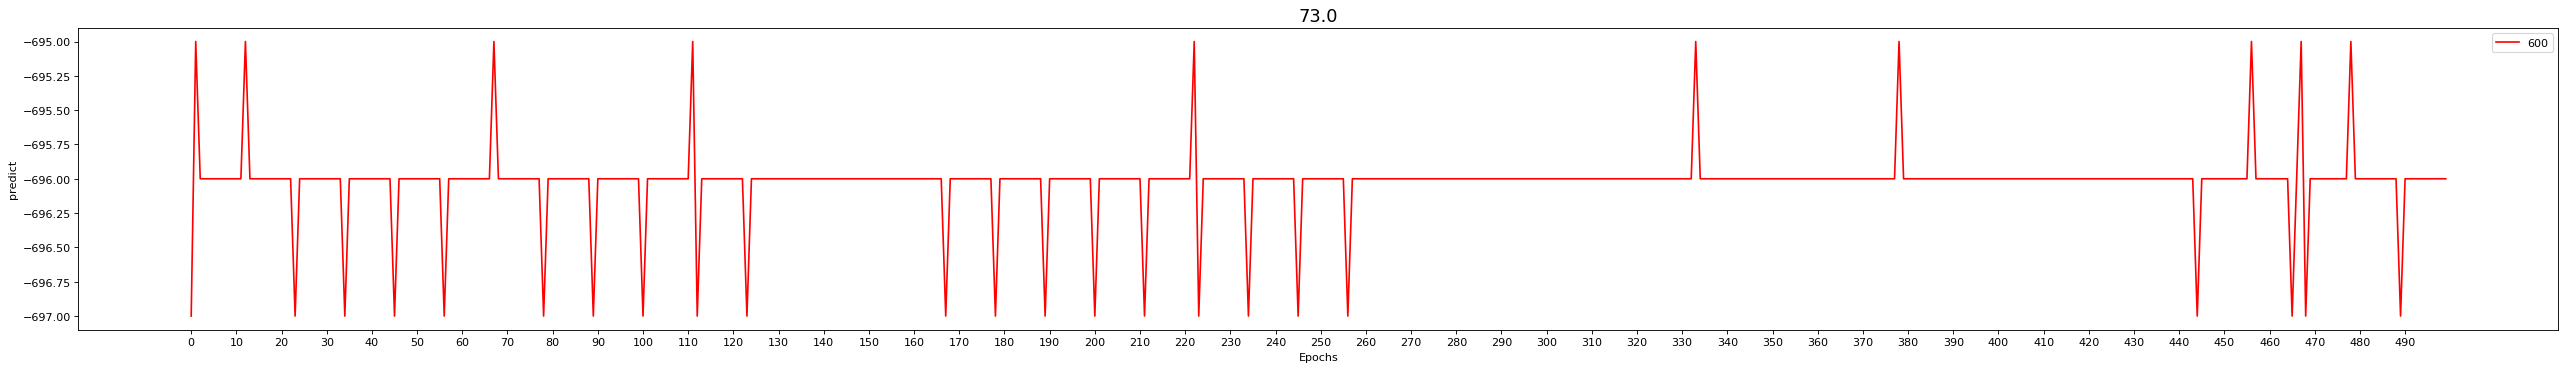

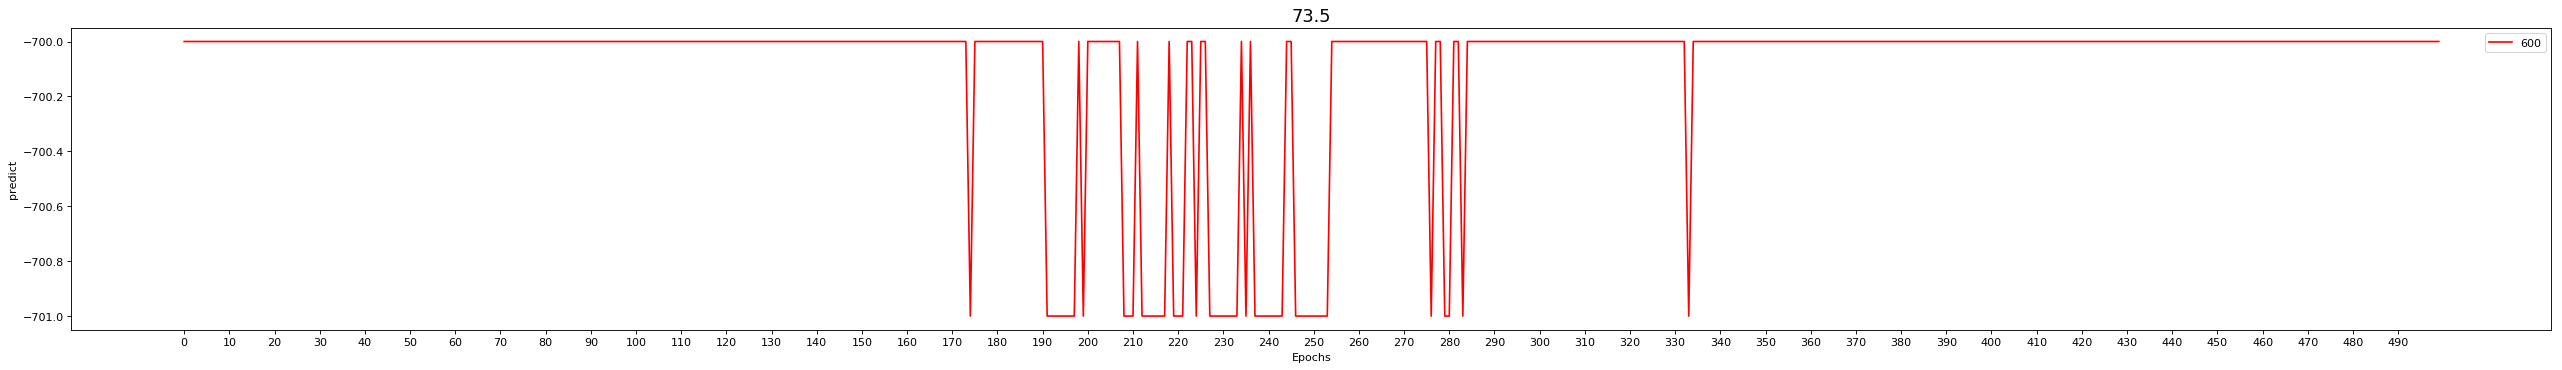

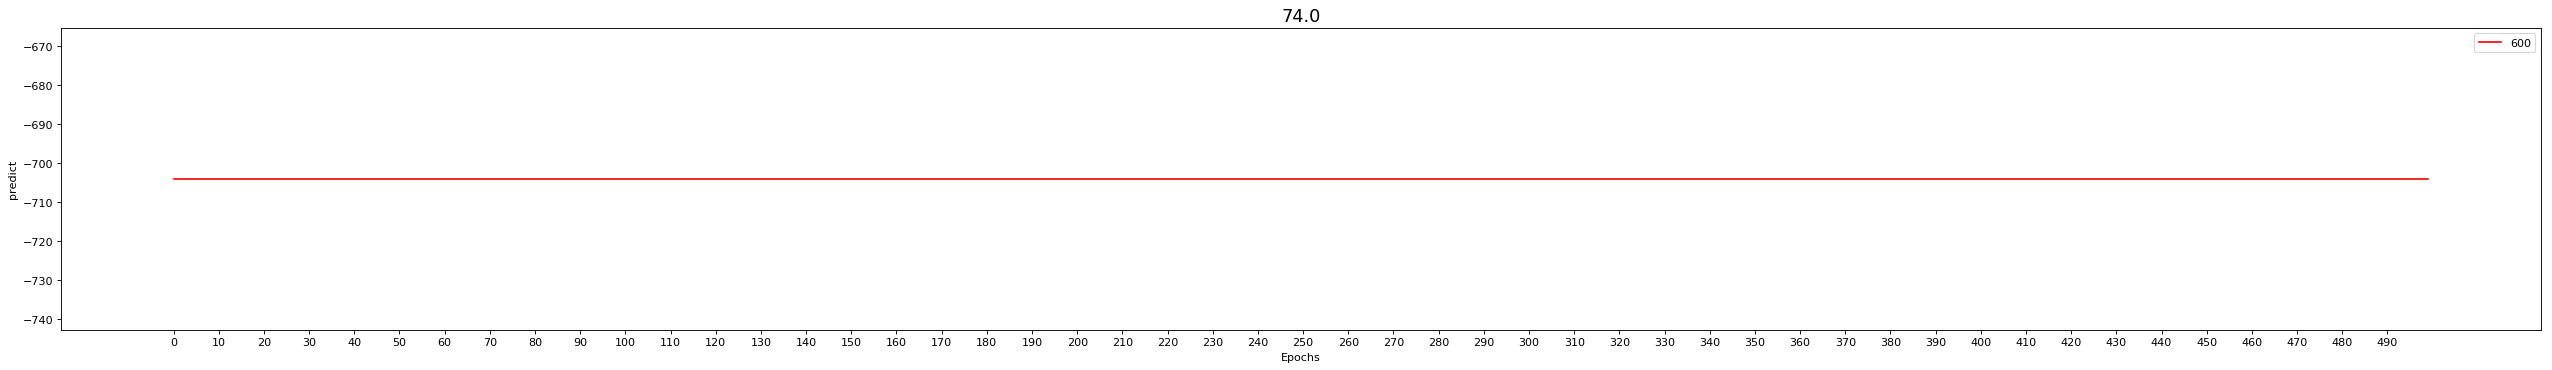

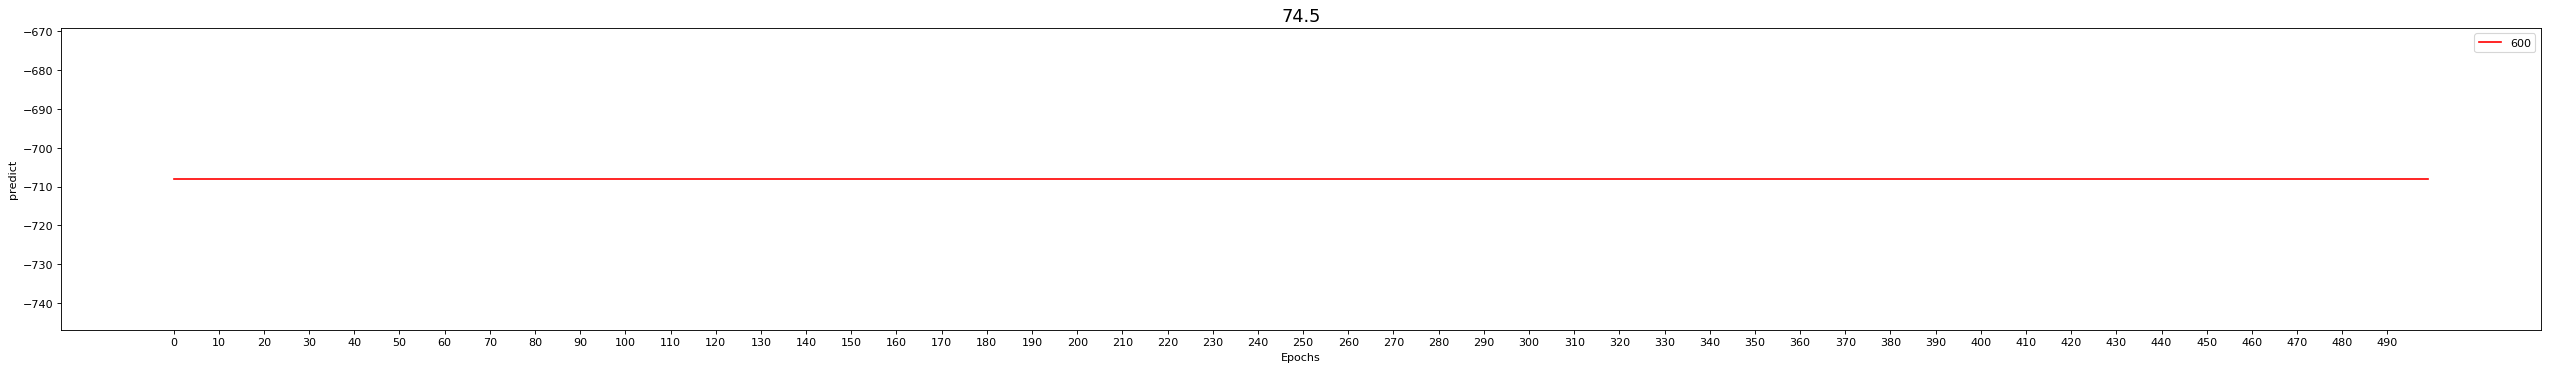

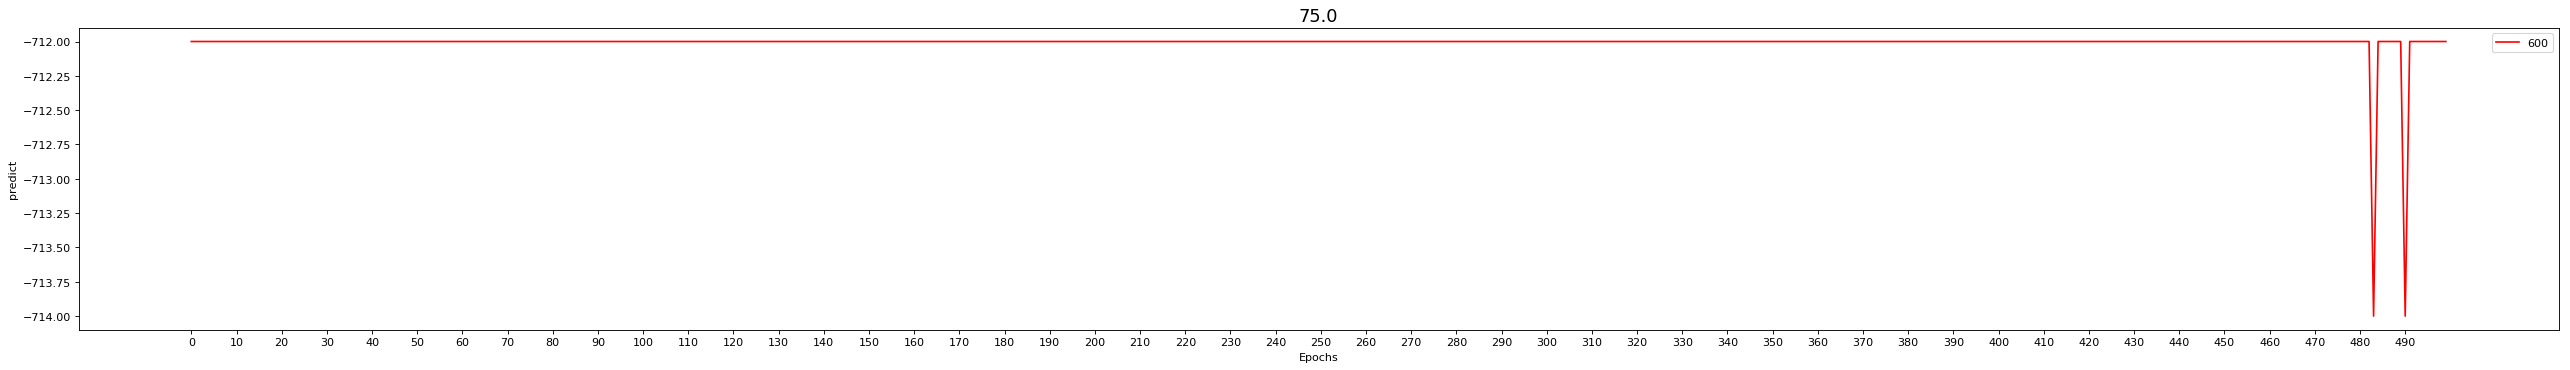

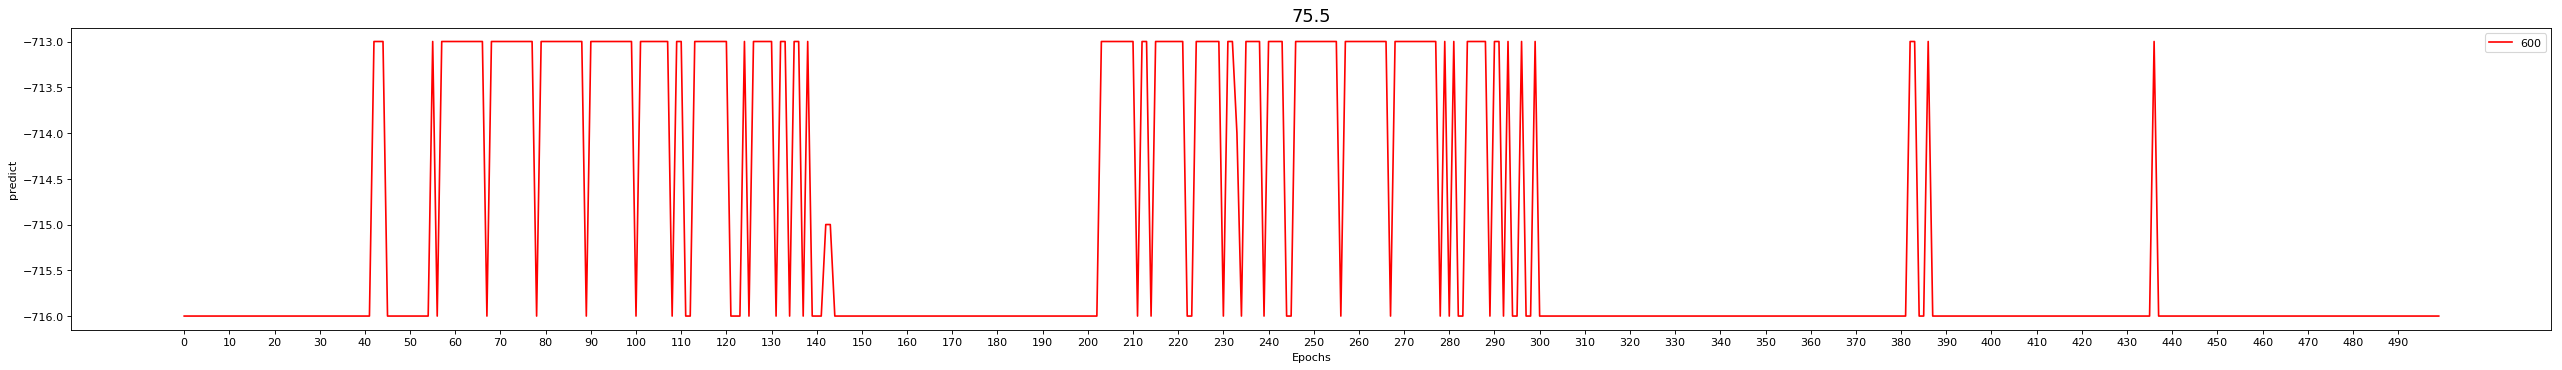

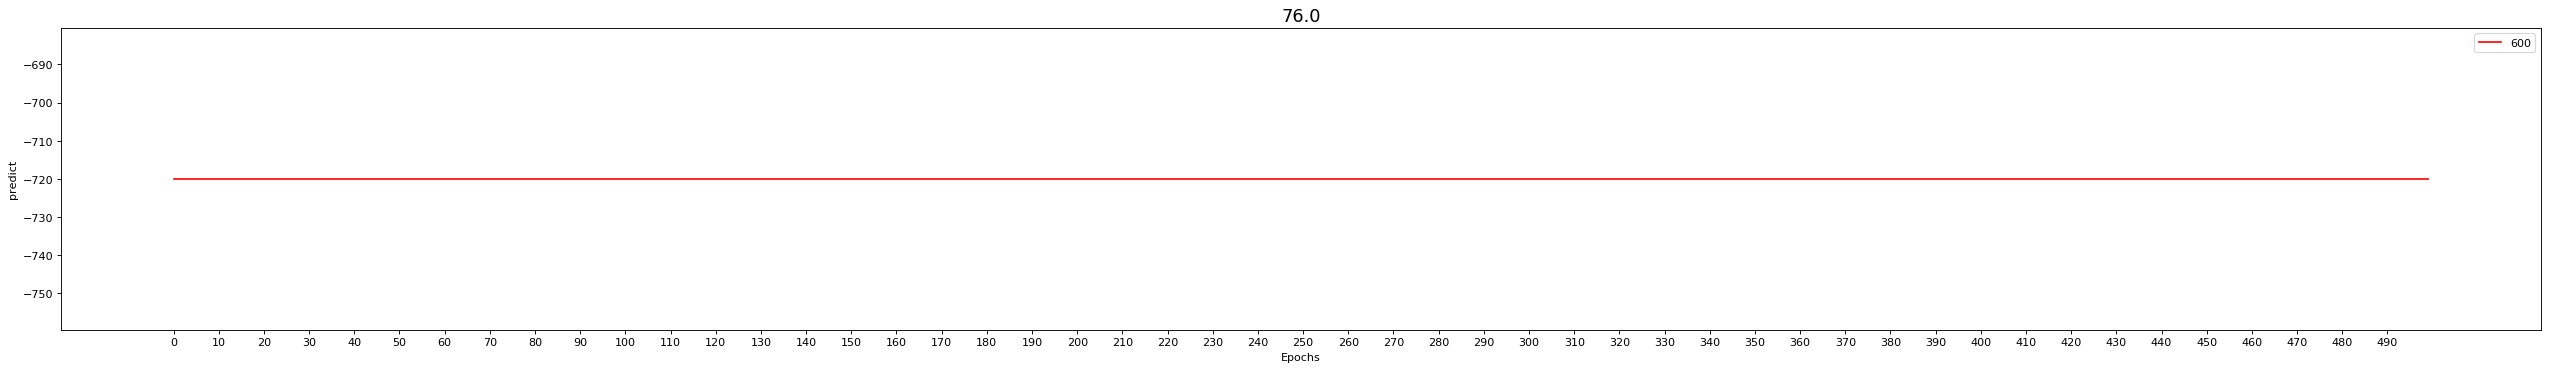

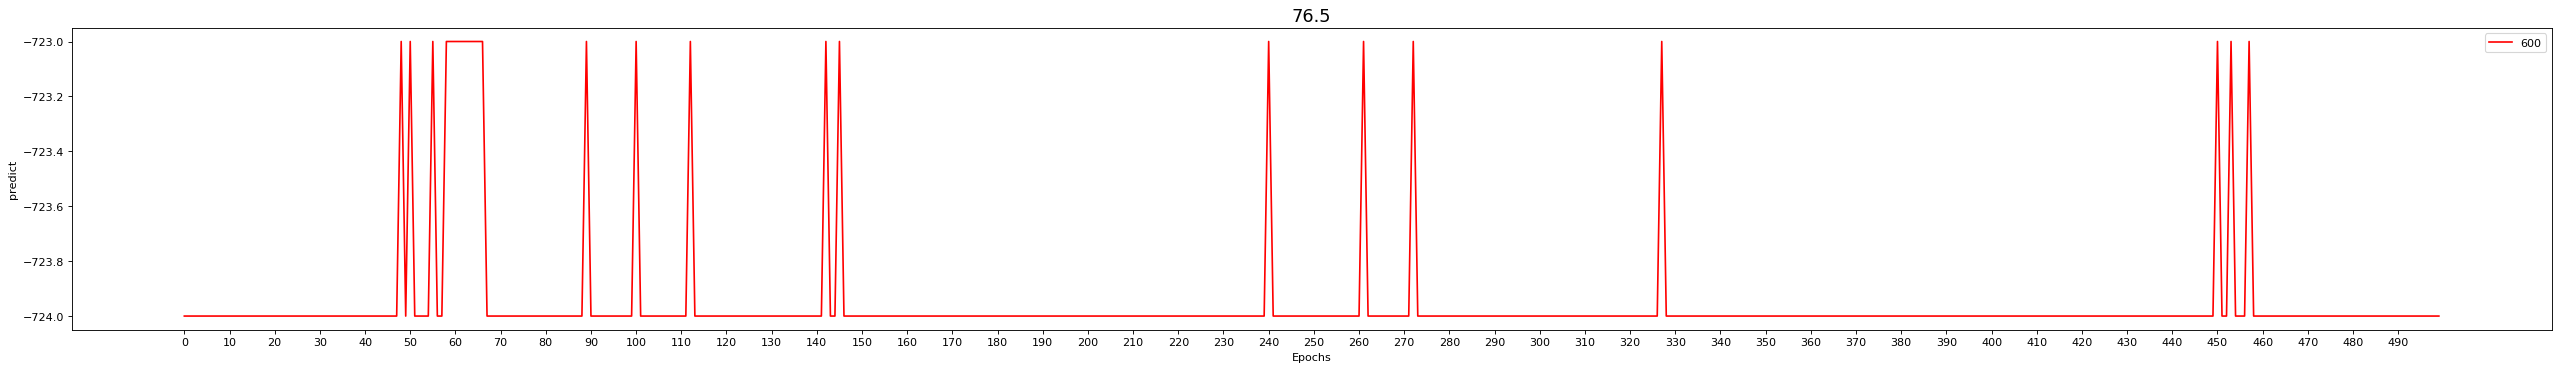

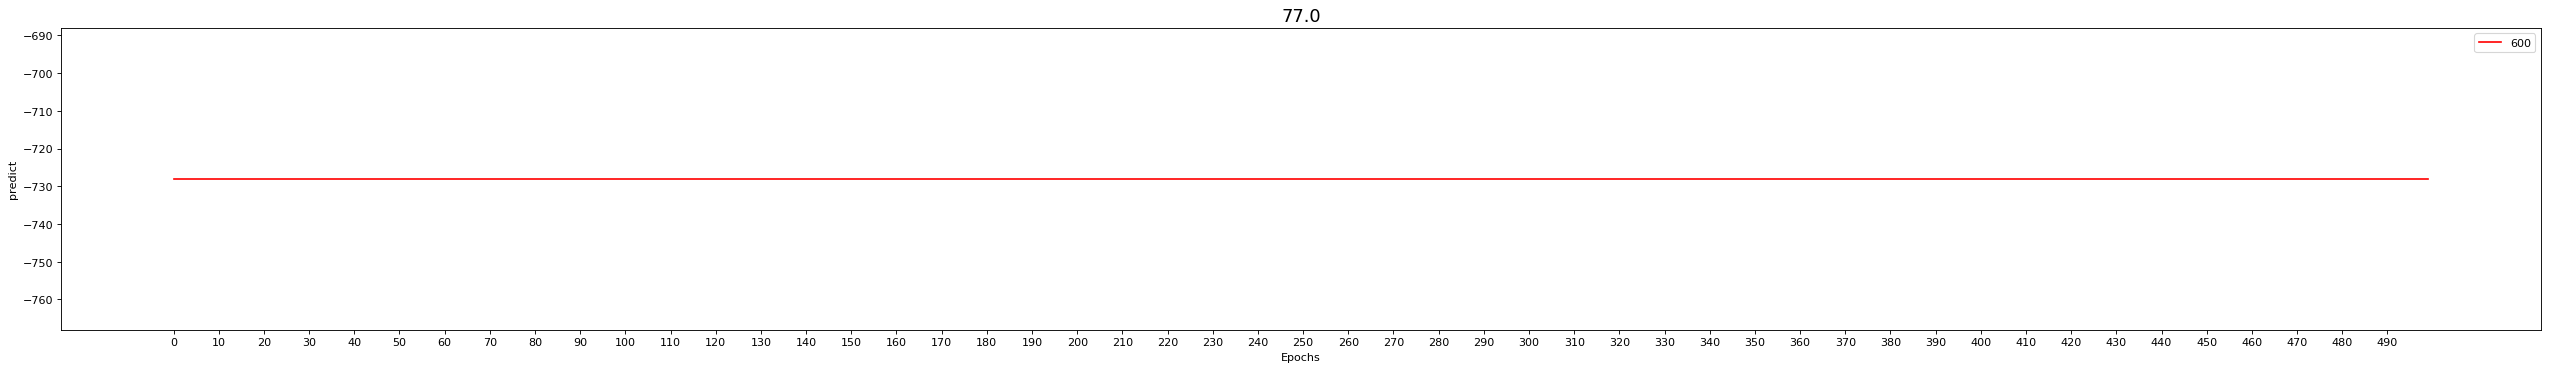

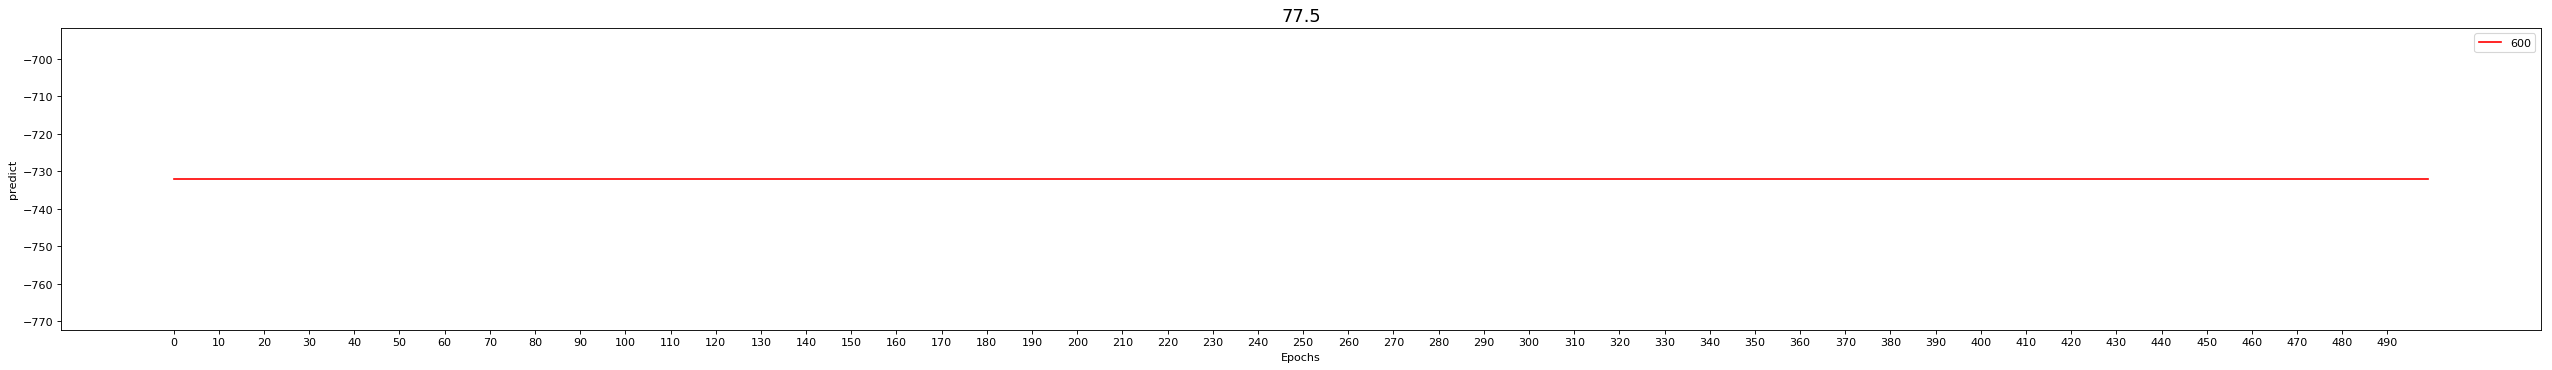

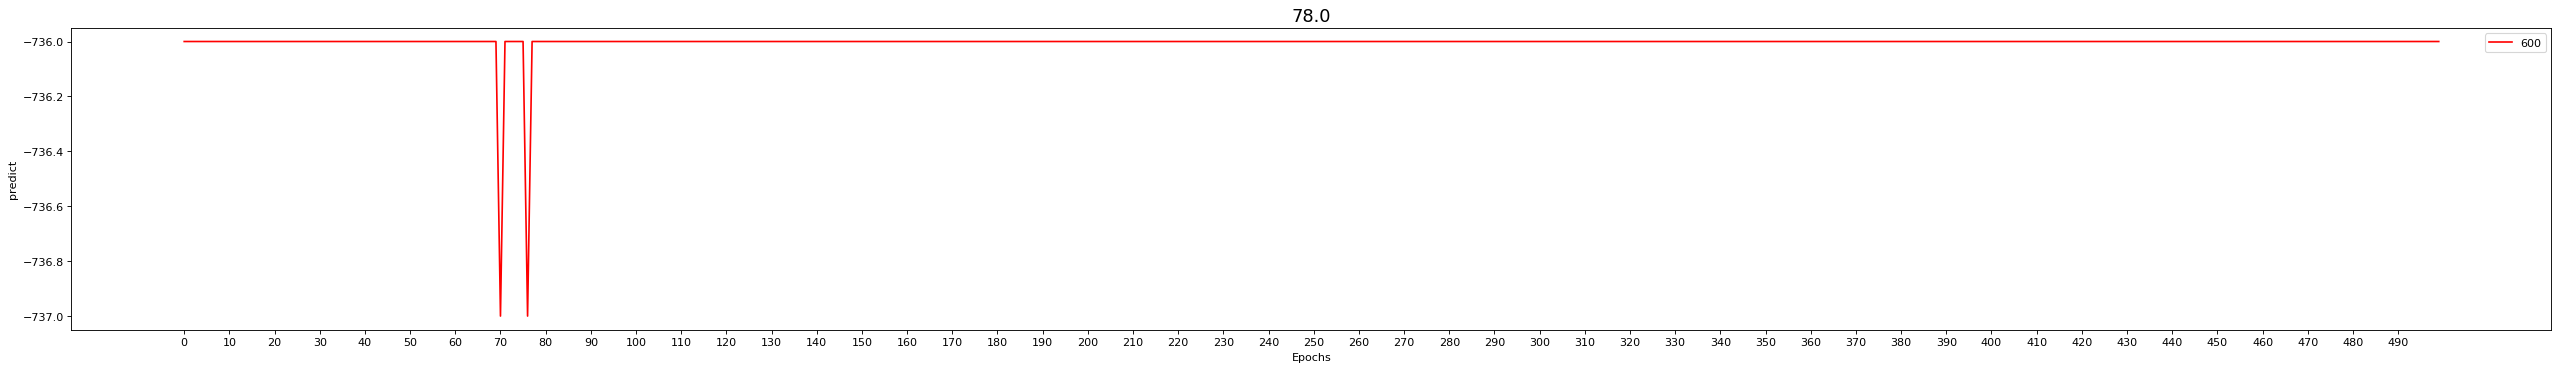

In [63]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

for label in range(num_classes):
    plt.figure(figsize=(40,5),dpi=80)
    plt.title(str(conc[label]),fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel("predict")
    plt.xticks(np.arange(0, 500, 10))
    plt.plot(range(500), matrix_conc[label],color='r', label='600')
    plt.legend()  # 设置图例和其中的文本的显示

plt.show()